In [2]:
import pandas as pd
import re
import argparse
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats
import researchpy as rp

In [6]:
pd.set_option("display.max_columns", None)
input_folder = 'data/data/train'
# Reading input folder
filesnames = os.listdir(input_folder)
regex = re.compile(r'\d+')
files = os.listdir(input_folder)

ids = [int(x) for x in regex.findall(str(files))]
dfs = list()

for patient_id, filename in enumerate(filesnames):    
    pdf = pd.read_csv(input_folder + "/" + filename, sep='|')   
    sepsislabel_true_list = pdf[pdf['SepsisLabel'] == 1].index
    if not sepsislabel_true_list.empty:
        pdf = pdf[:min(pdf[pdf['SepsisLabel'] == 1].index)+1]
        pdf['SepsisLabel'] = 1
    pdf['patient_id'] = ids[patient_id]
    pdf.interpolate(limit_direction='both', axis=0, inplace=True)
    dfs.append(pdf)
df = pd.concat(dfs, axis=0, ignore_index=True)

In [40]:
# data before interpolation

dfs = list()

for patient_id, filename in enumerate(filesnames):    
    pdf = pd.read_csv(input_folder + "/" + filename, sep='|')   
    sepsislabel_true_list = pdf[pdf['SepsisLabel'] == 1].index
    if not sepsislabel_true_list.empty:
        pdf = pdf[:min(pdf[pdf['SepsisLabel'] == 1].index)+1]
        pdf['SepsisLabel'] = 1
    pdf['patient_id'] = ids[patient_id]
    #pdf.interpolate(limit_direction='both', axis=0, inplace=True)
    dfs.append(pdf)
df_full = pd.concat(dfs, axis=0, ignore_index=True)

In [6]:
file_name = 'df.pkl'

# Save dataframe to pickled pandas object
#df.to_pickle(file_name) # where to save it usually as a .plk

# Load dataframe from pickled pandas object
df = pd.read_pickle(file_name)


In [7]:
# lab test features
labs = ['BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate',
      'Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

# vital signal features
vitals = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2']

# demographic features
demogs = ['Age','Gender','Unit1','Unit2','HospAdmTime','ICULOS']

# labels
labels = ['SepsisLabel']

all = vitals+labs+demogs+labels


Text(0.5, 1.0, 'Percentage of Patients With Sepsis')

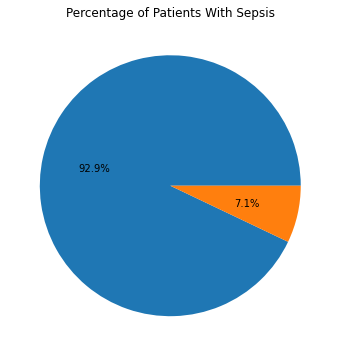

In [8]:
grouped = df.groupby('SepsisLabel').agg({"patient_id":pd.Series.nunique})/len(df.groupby('patient_id'))
labels = 'No Sepsis', 'Sepsis'

grouped.patient_id.plot.pie(subplots=True,figsize=(6, 6),labels=labels,label="", autopct='%1.1f%%',labeldistance=None)
plt.title('Percentage of Patients With Sepsis')

<AxesSubplot:>

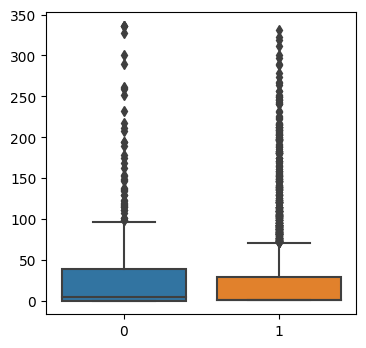

In [9]:
import seaborn as sns
ICULOS_df = df[['patient_id','SepsisLabel','ICULOS']].groupby(by='patient_id').max().rename(columns={'ICULOS':'ICULOS max'})
non_septic = ICULOS_df[ICULOS_df['SepsisLabel']==0]
septic = ICULOS_df[ICULOS_df['SepsisLabel']==1]
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

sns.boxplot(data=[non_septic,septic],ax=ax)

# ICULOS_df = pd.DataFrame({'spesis': septic, 'no sepsis':non_septic}, columns = ['spesis', 'no sepsis'])
# ICULOS_df
#max_los.groupby(by='SepsisLabel').boxplot(rot=45, fontsize=12, figsize=(8,10))

ICU stay time

C:\Users\Gal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


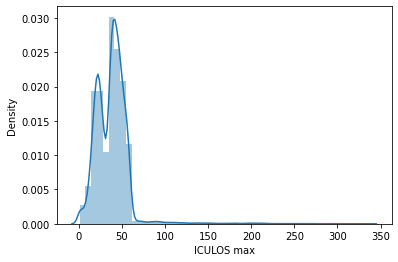

In [10]:
ax = sns.distplot(ICULOS_df['ICULOS max'])

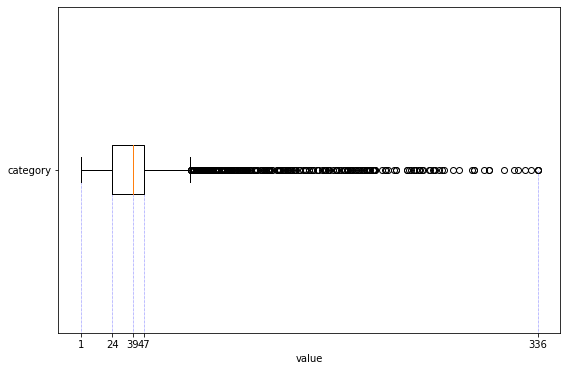

In [11]:
import numpy as np
import matplotlib.pylab as plt

vel_arr = ICULOS_df['ICULOS max']
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

ax.boxplot(vel_arr, vert=False, manage_ticks=True)
ax.set_xlabel('value')
ax.set_yticks([1])
ax.set_yticklabels(['category'])

quantiles = np.quantile(vel_arr, np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.show()

CHECKING CORELLATION

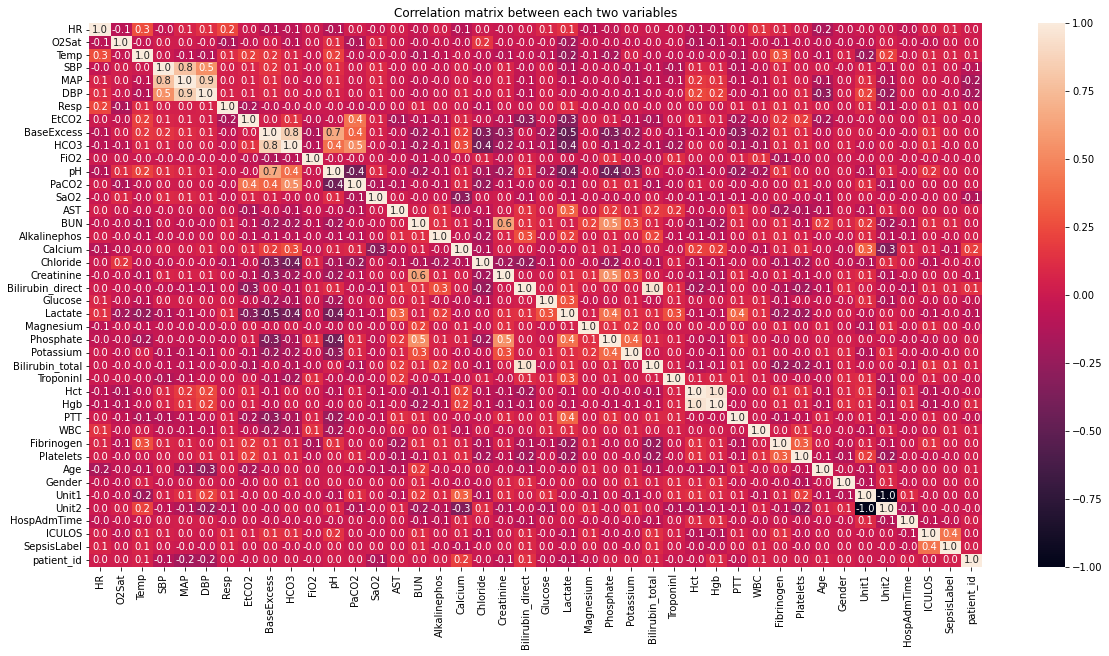

In [12]:
import seaborn as sns

plt.figure(figsize = (20,10))

ax = sns.heatmap(data=df.corr(), annot=True, fmt='.1f').set(
    title='Correlation matrix between each two variables')

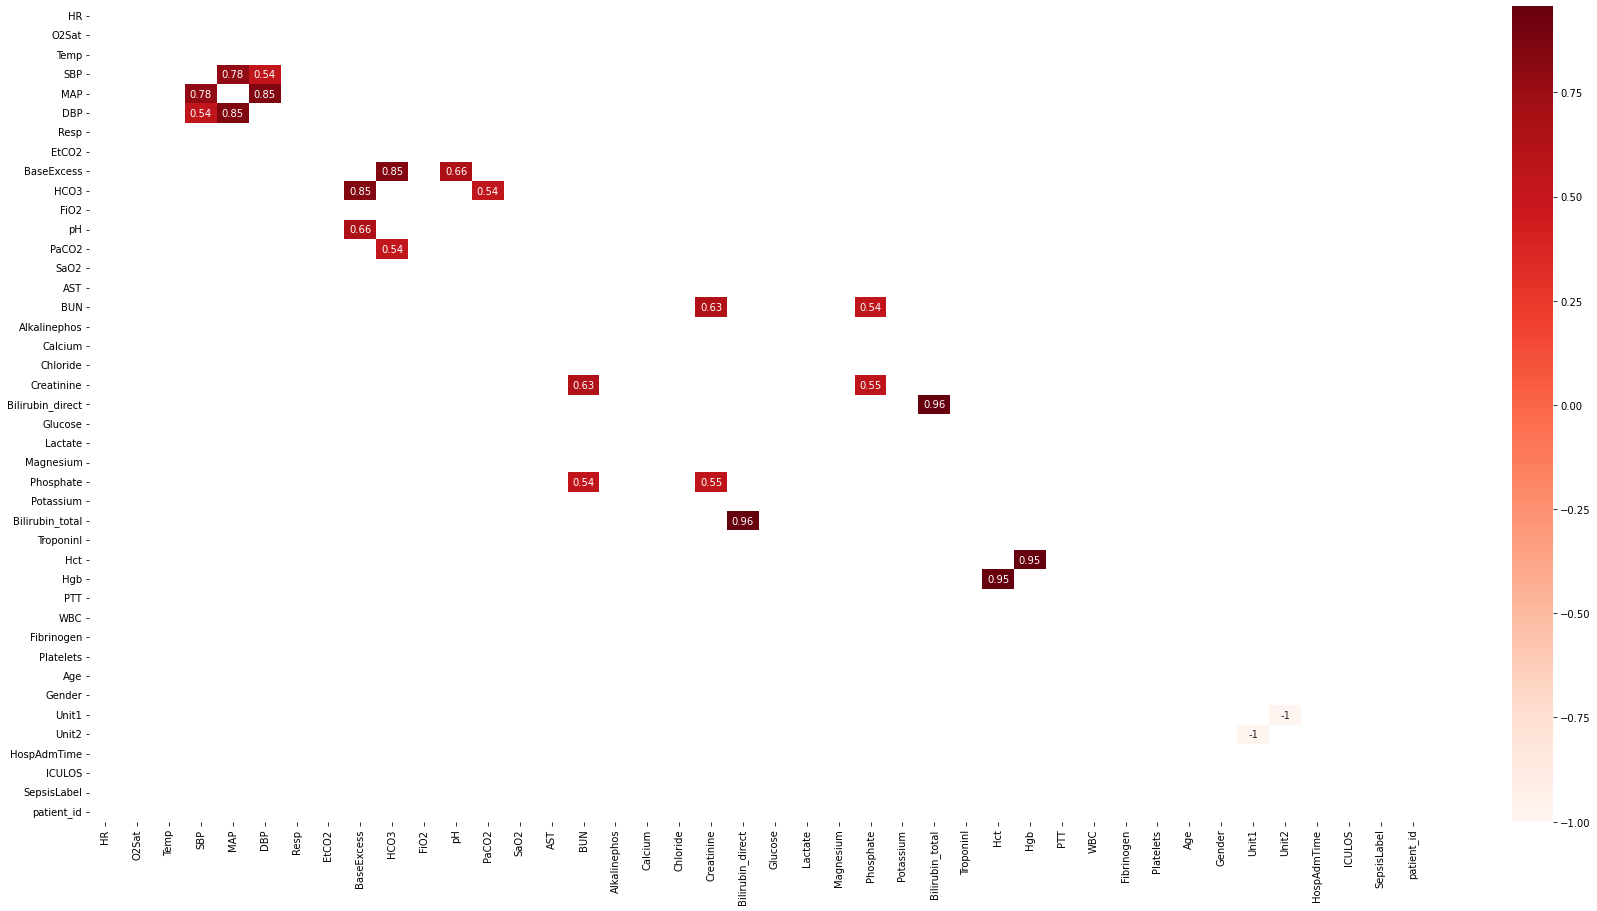

In [13]:
dfCorr = df.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,15))
ax = sns.heatmap(filteredDf, annot=True, cmap="Reds")


In [14]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(df, .7)

Unit1             Unit2             -1.000000
SBP               MAP                0.781767
BaseExcess        HCO3               0.848216
MAP               DBP                0.851345
Hct               Hgb                0.953687
Bilirubin_direct  Bilirubin_total    0.956440
HR                HR                      NaN
dtype: float64

In [15]:
labs_df = df[labs]
vitals_df = df[vitals]
demogs_df = df[demogs]
df_sepsis = df[df['SepsisLabel'] == 1]
df_not_sepsis = df[df['SepsisLabel'] == 0]

In [16]:
data_mean = df.groupby('patient_id').mean()
data_sepsis_mean = df_sepsis.groupby('patient_id').mean()
data_not_sepsis_mean = df_not_sepsis.groupby('patient_id').mean()

In [17]:
sepsis_missing = data_sepsis_mean.isnull().sum() * 100 / len(data_sepsis_mean)

In [18]:
not_sepsis_missing = data_not_sepsis_mean.isnull().sum() * 100 / len(data_not_sepsis_mean)

In [19]:
pd.concat([sepsis_missing,not_sepsis_missing],axis=1)


,0,1
HR,12.367491,0.016142
O2Sat,12.720848,0.059188
Temp,16.819788,0.618779
SBP,17.455830,0.435835
MAP,12.650177,0.236750
DBP,29.328622,17.976863
Resp,13.286219,0.145278
EtCO2,87.420495,92.929782
BaseExcess,55.759717,68.732849
HCO3,50.954064,51.116492


In [20]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values()

patient_id           0.000000
ICULOS               0.000000
HospAdmTime          0.000000
Gender               0.000000
Age                  0.000000
SepsisLabel          0.000000
HR                   9.952611
MAP                 12.551122
O2Sat               13.120266
SBP                 14.710585
Resp                15.460834
DBP                 31.222402
Unit1               38.910491
Unit2               38.910491
Temp                66.091251
Glucose             82.850280
Potassium           90.725169
Hct                 91.158519
FiO2                91.843321
Hgb                 92.644177
pH                  93.096075
BUN                 93.185898
WBC                 93.637266
Magnesium           93.747491
Creatinine          93.950984
Platelets           94.102014
Calcium             94.189320
PaCO2               94.488598
BaseExcess          94.592597
Chloride            95.525670
HCO3                95.882446
Phosphate           96.056660
EtCO2               96.539956
SaO2      

Features with above 90 missingness

In [22]:
percent_missing = df.isnull().sum() * 100 / len(df)

missingtodrop = percent_missing[percent_missing>90].index

In [23]:
missingtodrop

Index(['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
       'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets'],
      dtype='object')

41


Text(0.5, 1.0, 'Quantifying missing data')

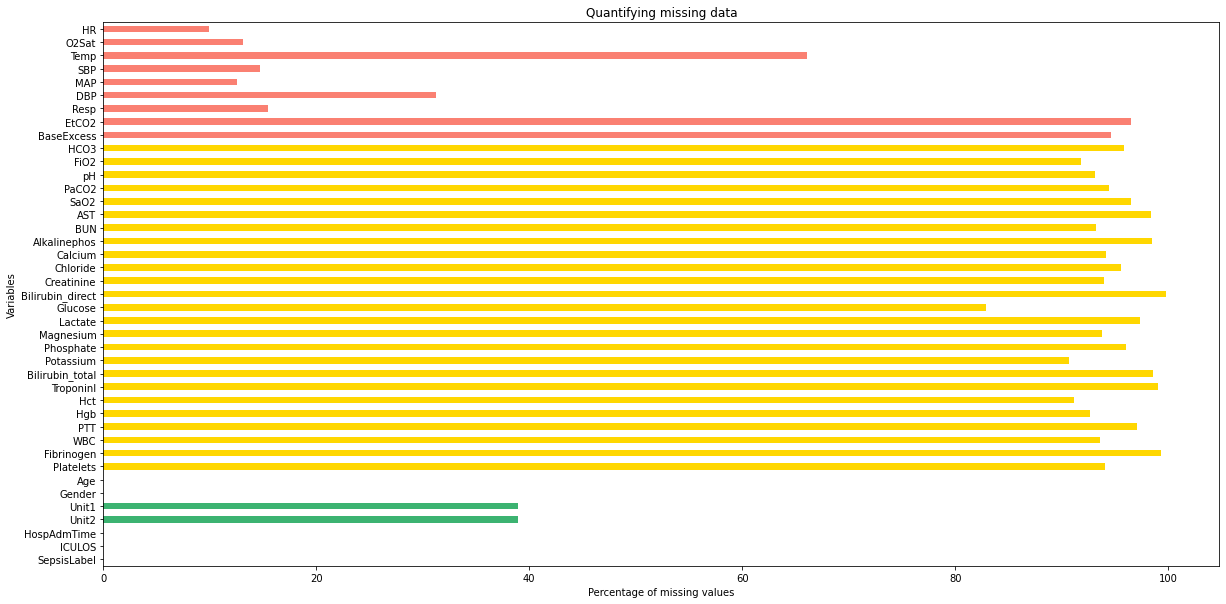

In [24]:
# check how to create legend: vital,demo,lab
# check https://inside-techlabs.medium.com/early-prediction-of-sepsis-from-clinical-data-a70f0fabb9d1

clrs = (['salmon']*9+['gold']*26+['mediumseagreen']*6)

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)

ax = missing_value_df.reindex(all[::-1]).plot.barh(figsize=(20,10))

print(len(ax.patches))
for patch,color in zip(ax.patches,clrs[::-1]):
    patch.set_facecolor(color)

labels = ['Vital','Lab','Demographic']
ax.get_legend().remove()

plt.ylabel('Variables')
plt.xlabel('Percentage of missing values')
plt.title('Quantifying missing data')

In [25]:
plt.rcParams["figure.figsize"] = (20,5)

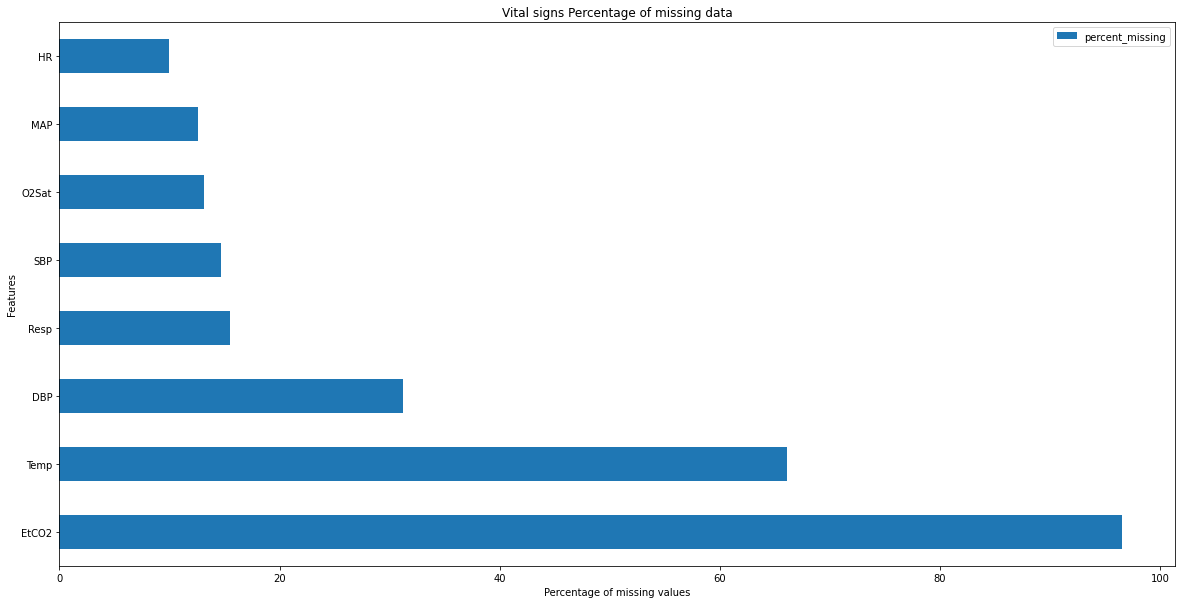

In [26]:
vitals_percent_missing = vitals_df.isnull().sum() * 100 / len(vitals_df)
vitals_missing_value_df = pd.DataFrame({'column_name': vitals_df.columns,
                                 'percent_missing': vitals_percent_missing})
vitals_missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
vitals_missing_value_df.plot.barh(figsize=(20,10))
plt.xlabel('Percentage of missing values')
plt.ylabel('Features')
plt.title(f'Vital signs Percentage of missing data')
plt.show()

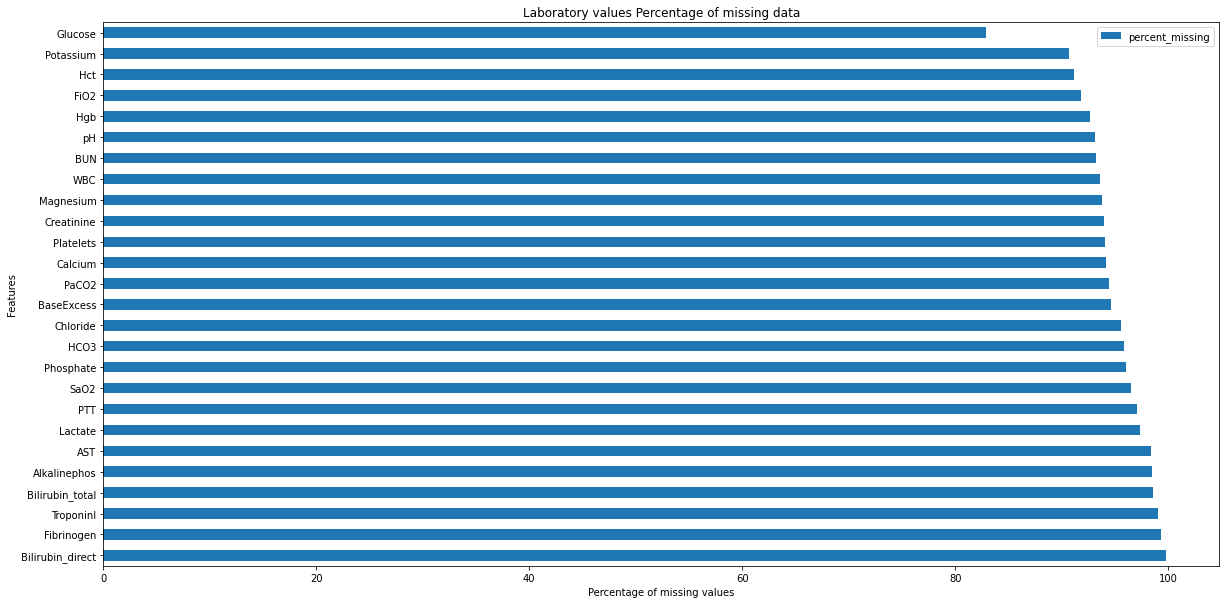

In [27]:
labs_percent_missing = labs_df.isnull().sum() * 100 / len(labs_df)
labs_missing_value_df = pd.DataFrame({'column_name': labs_df.columns,
                                 'percent_missing': labs_percent_missing})
labs_missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
labs_missing_value_df.plot.barh(figsize=(20,10))
plt.xlabel('Percentage of missing values')
plt.ylabel('Features')
plt.title(f'Laboratory values Percentage of missing data')
plt.show()

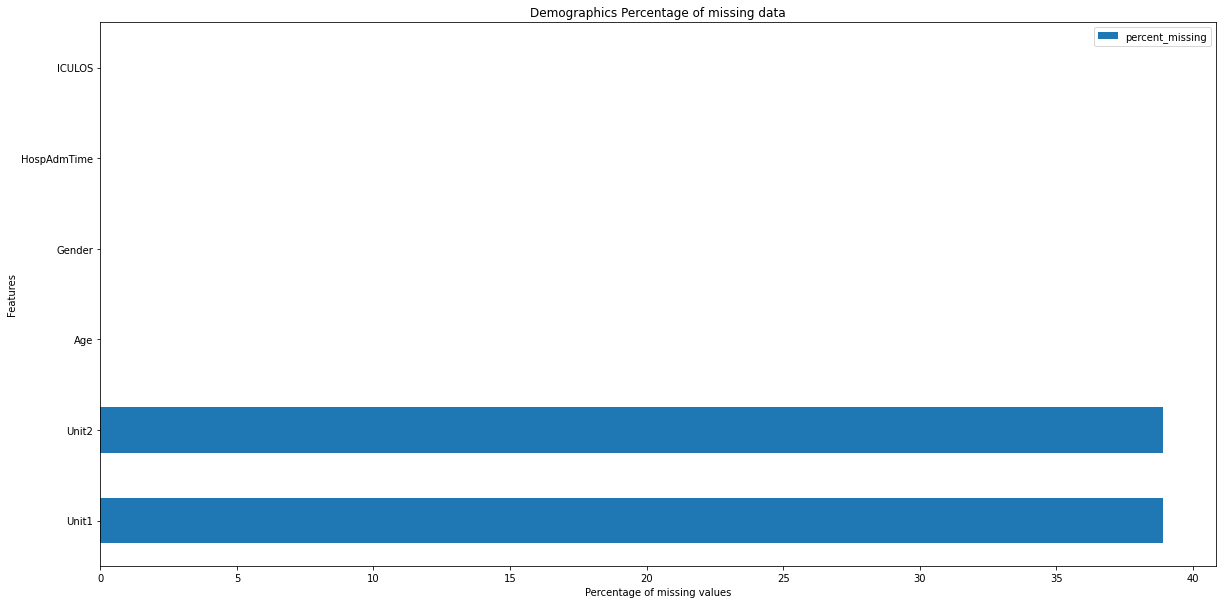

In [28]:
demogs_percent_missing = demogs_df.isnull().sum() * 100 / len(demogs_df)
demogs_missing_value_df = pd.DataFrame({'column_name': demogs_df.columns,
                                 'percent_missing': demogs_percent_missing})
demogs_missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
demogs_missing_value_df.plot.barh(figsize=(20,10))
plt.xlabel('Percentage of missing values')
plt.ylabel('Features')
plt.title(f'Demographics Percentage of missing data')
plt.show()

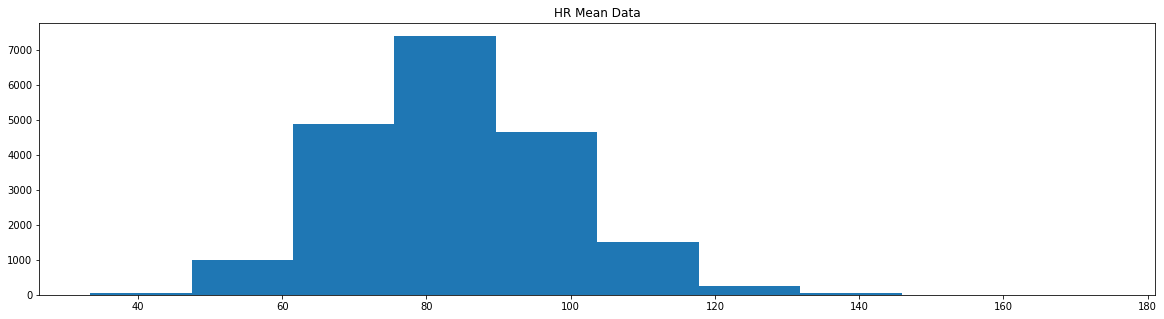

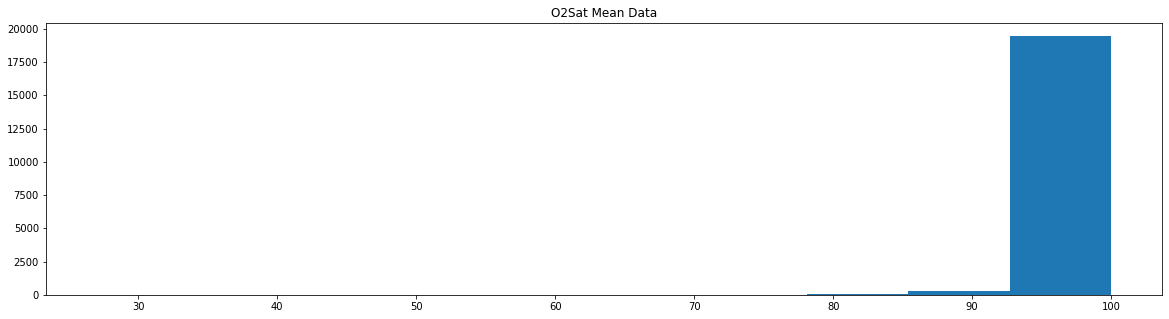

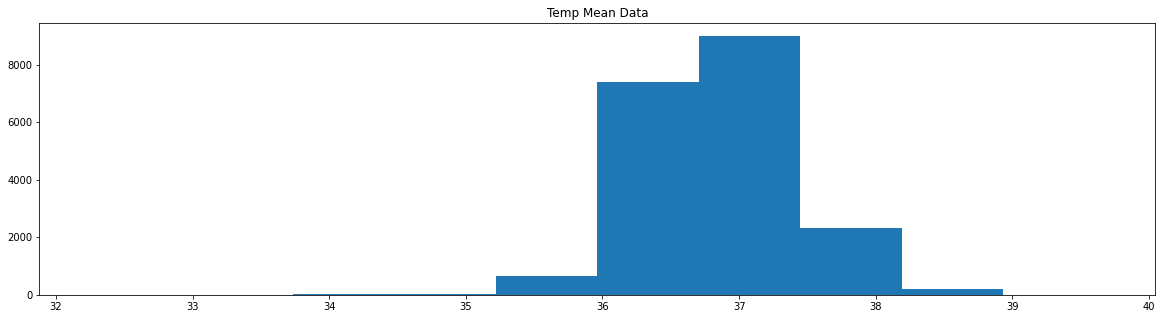

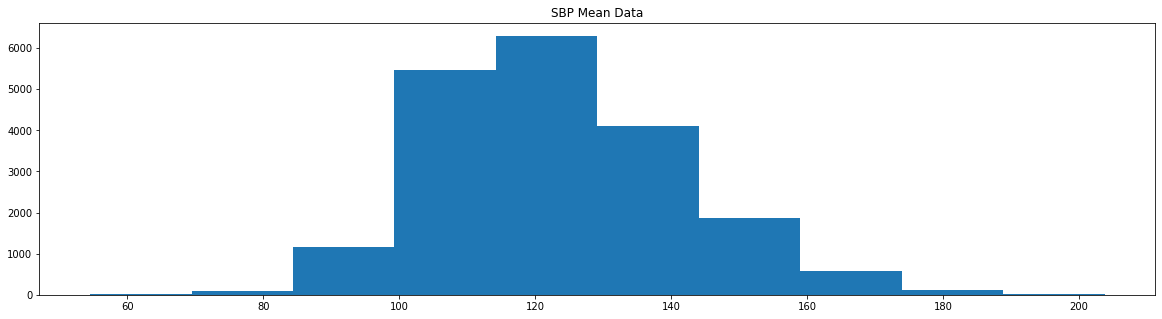

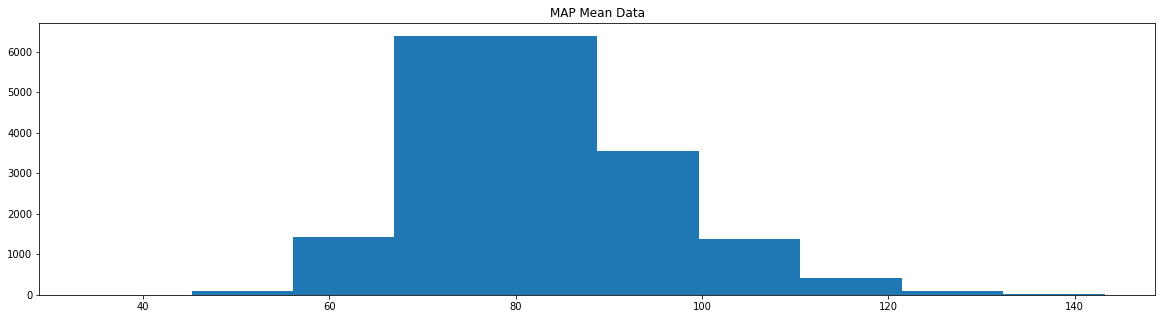

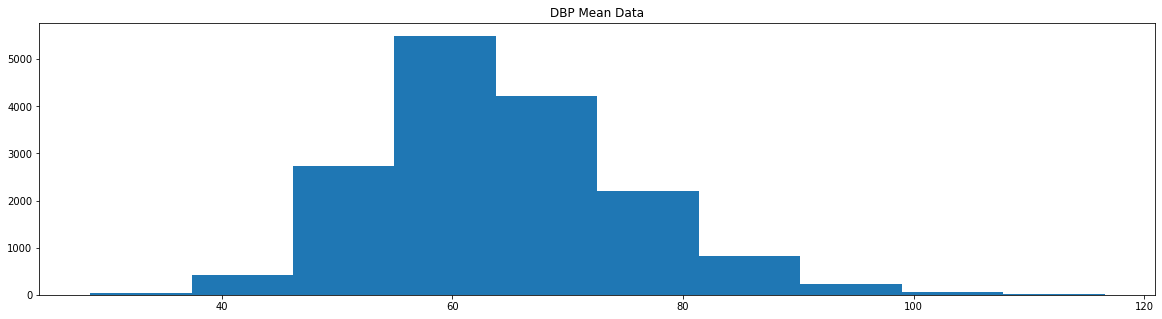

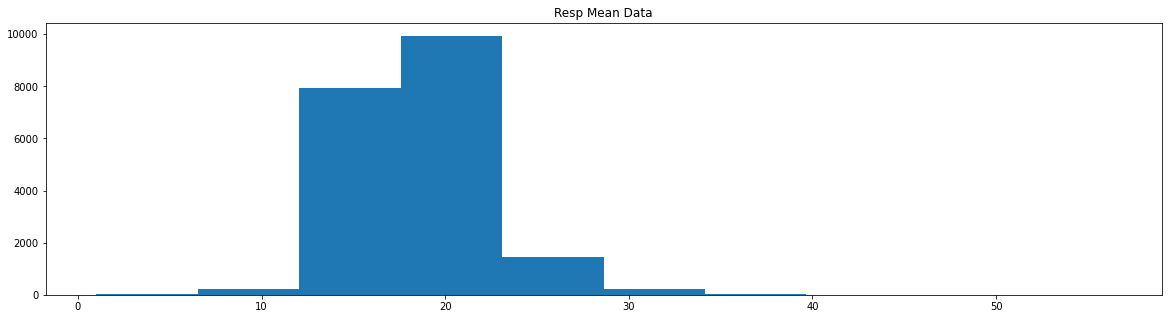

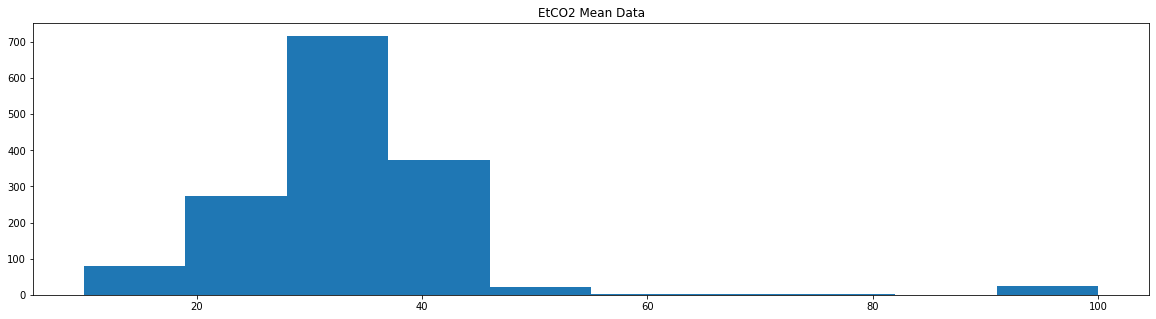

In [29]:
for vital in vitals:
    plt.hist(data_mean[vital].dropna())
    plt.title(f'{vital} Mean Data')
    plt.show()

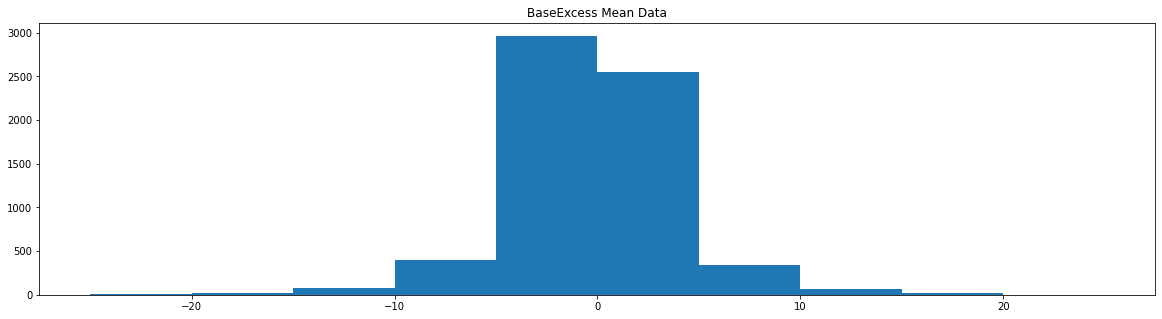

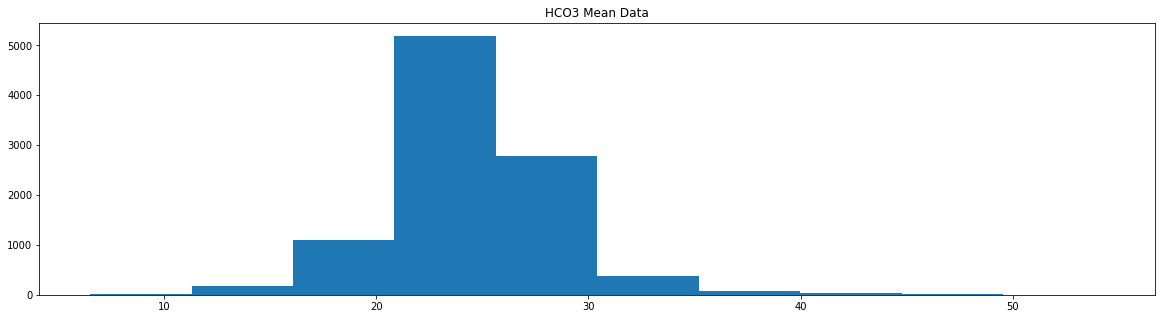

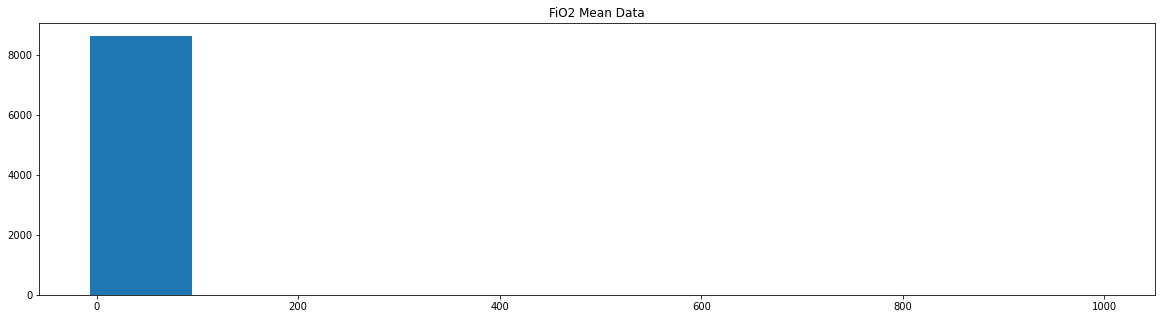

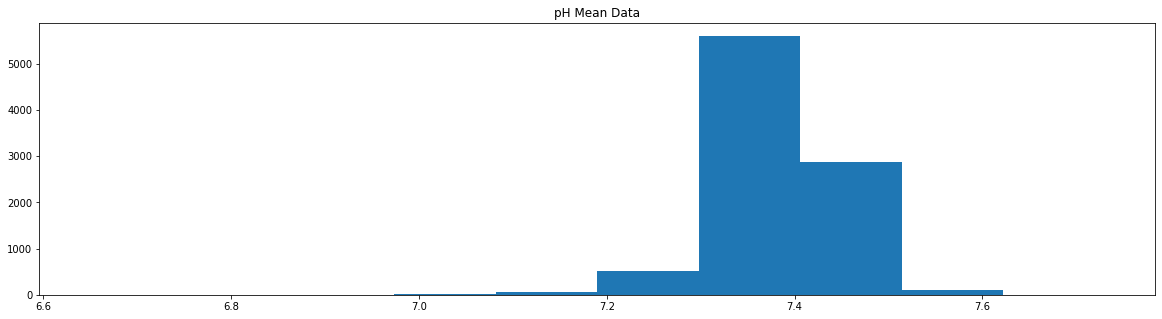

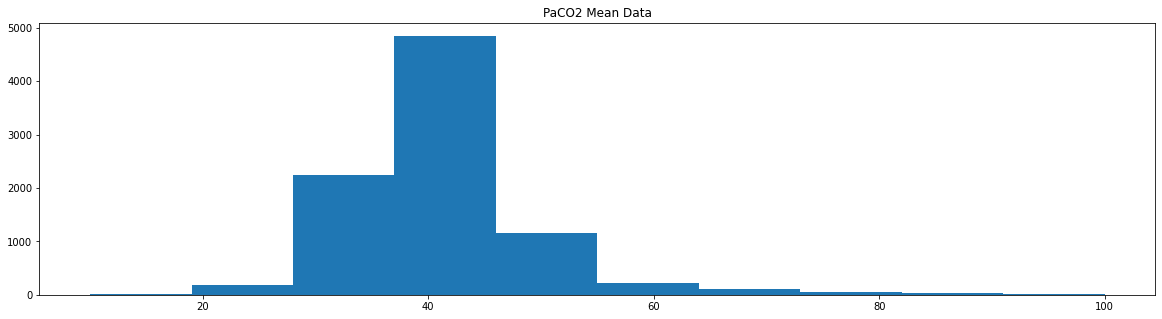

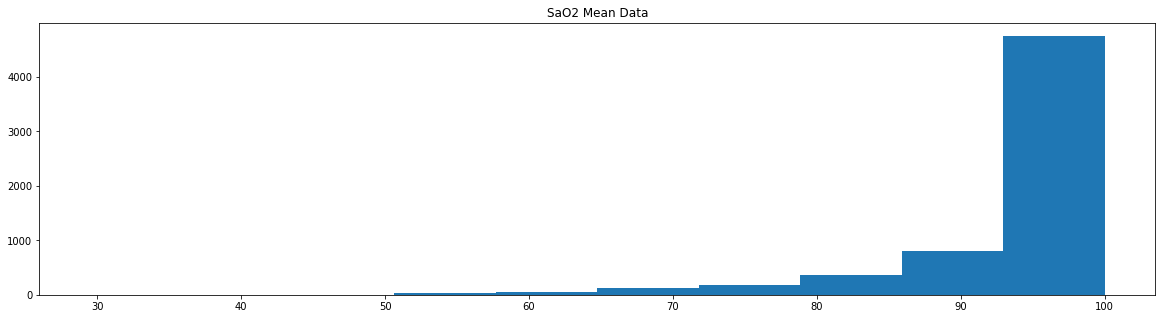

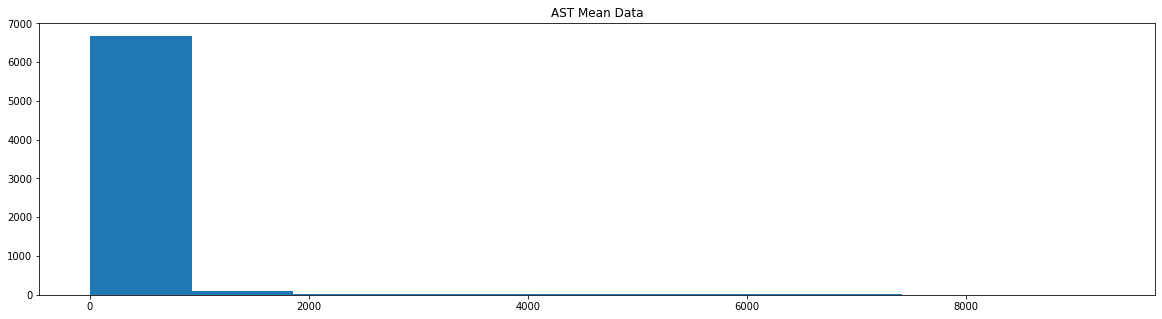

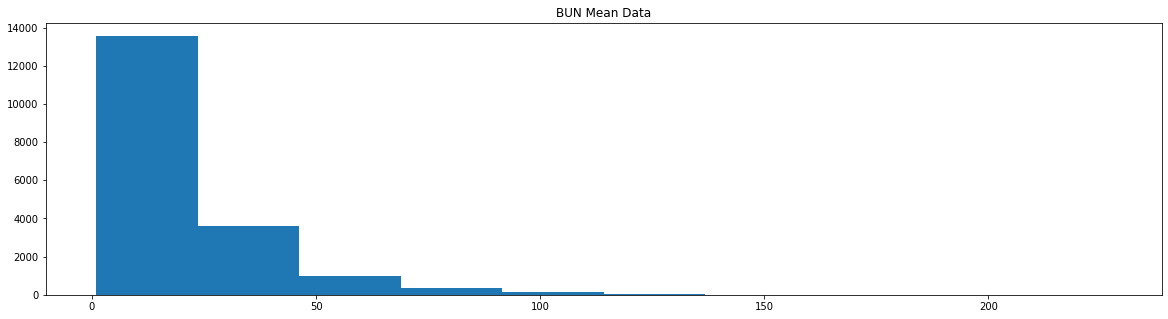

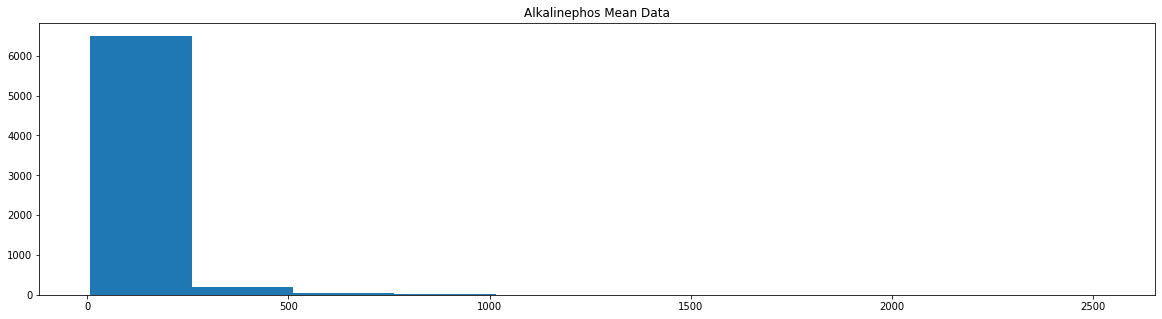

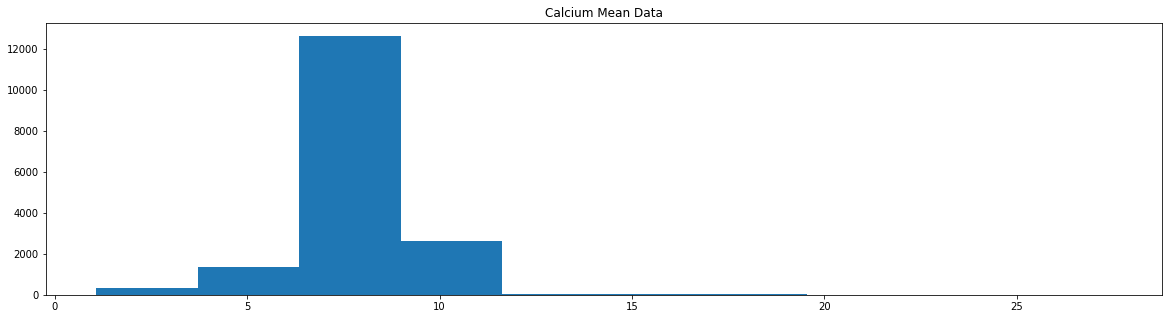

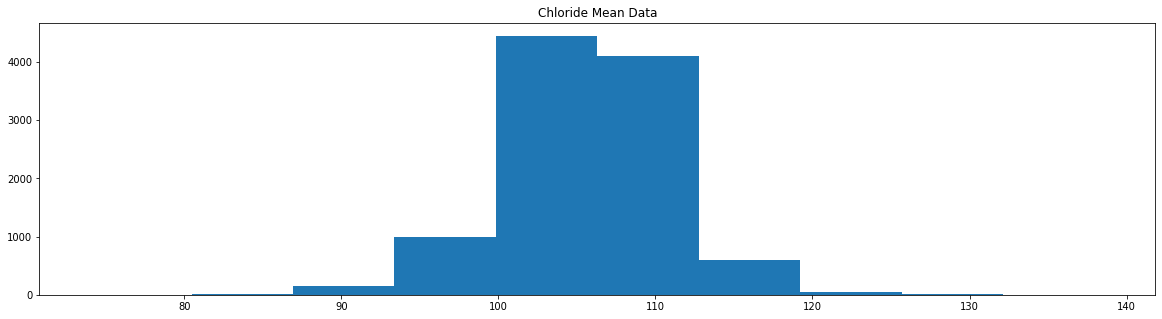

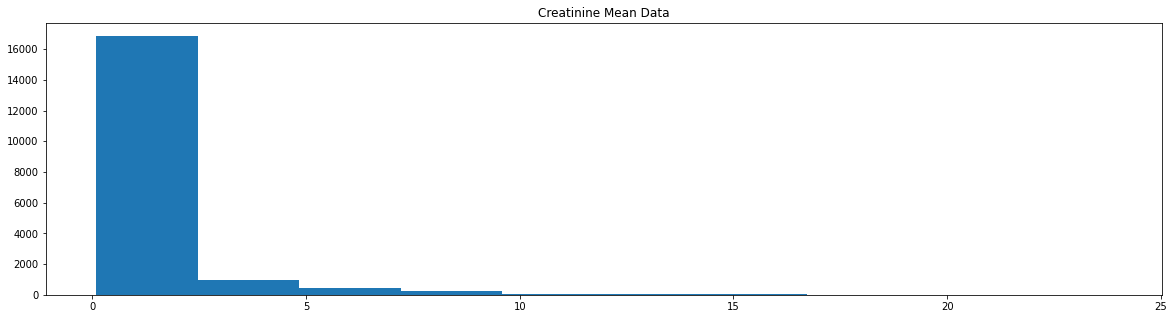

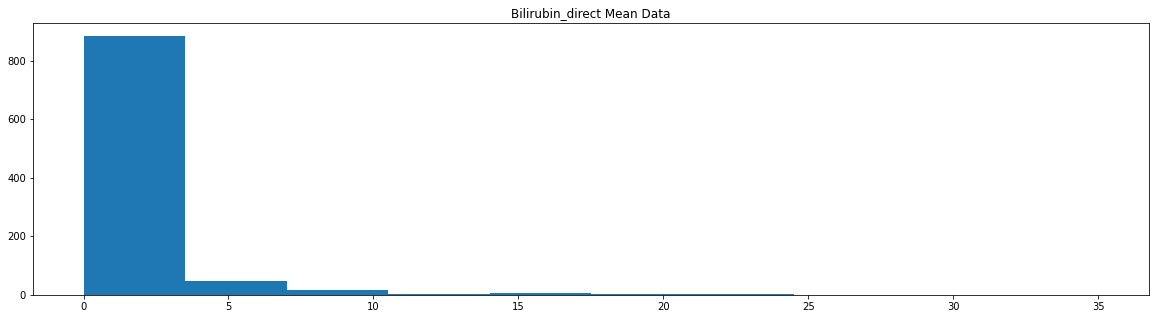

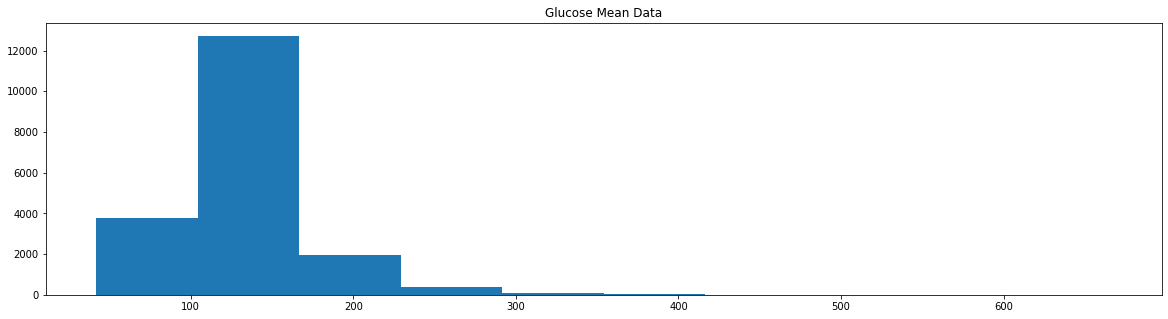

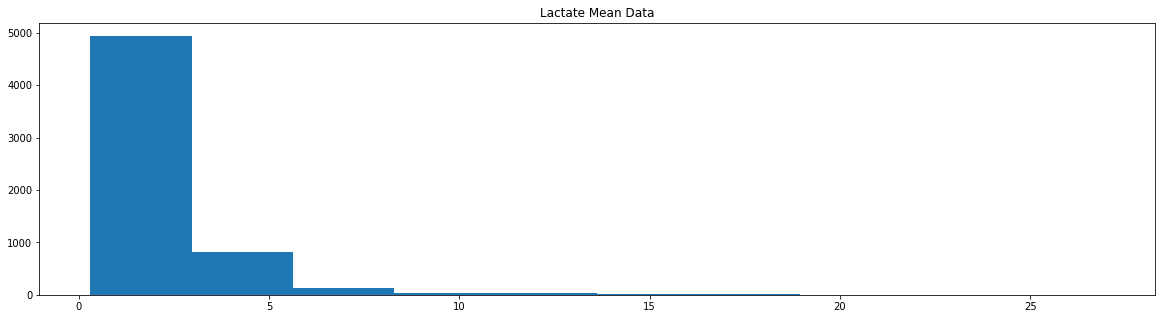

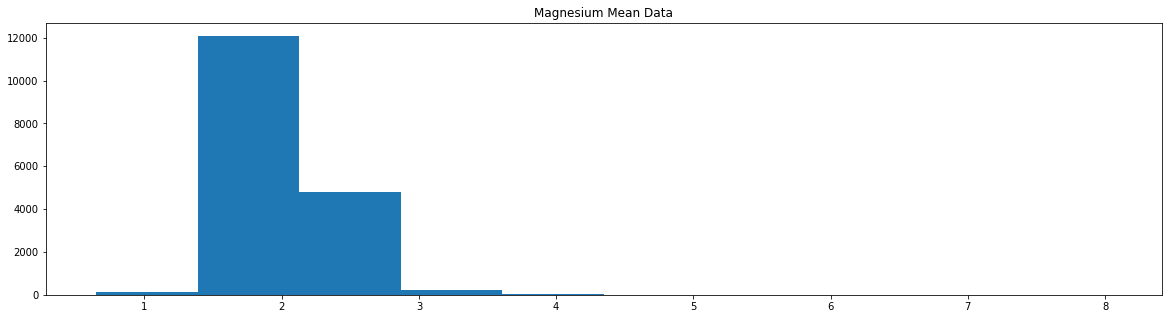

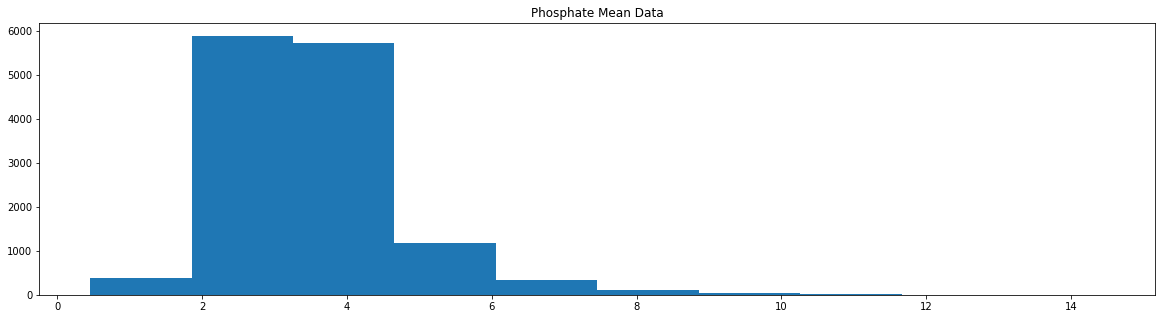

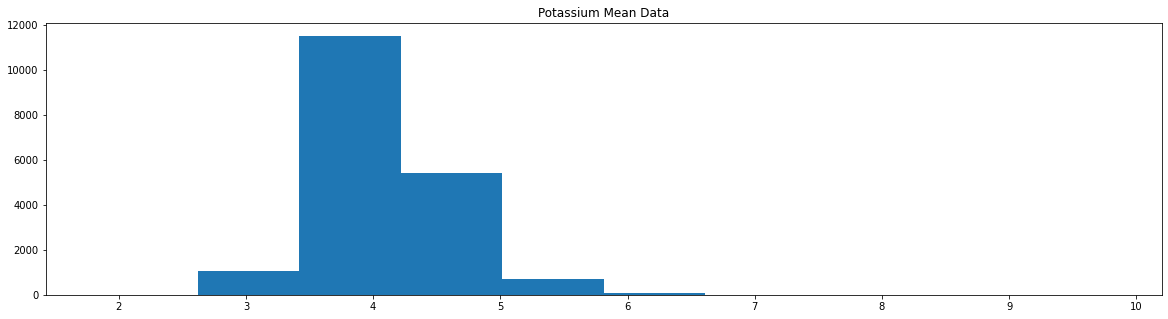

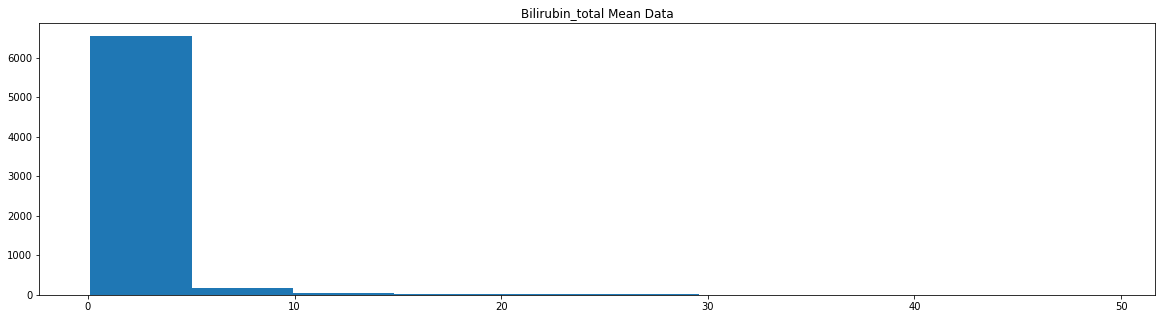

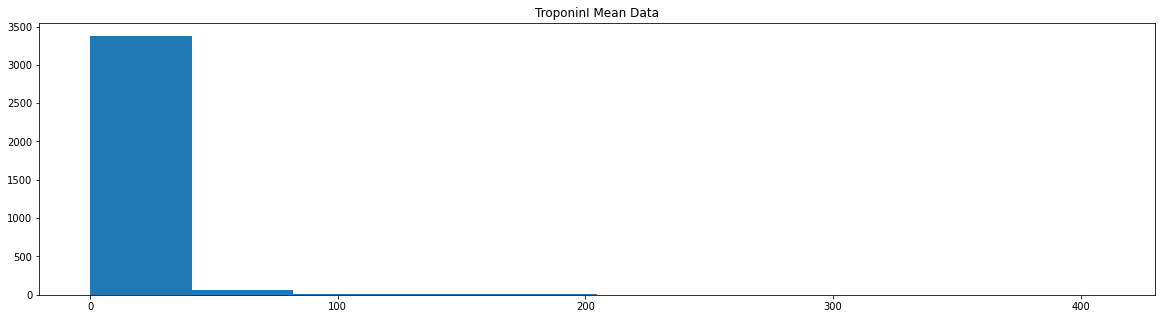

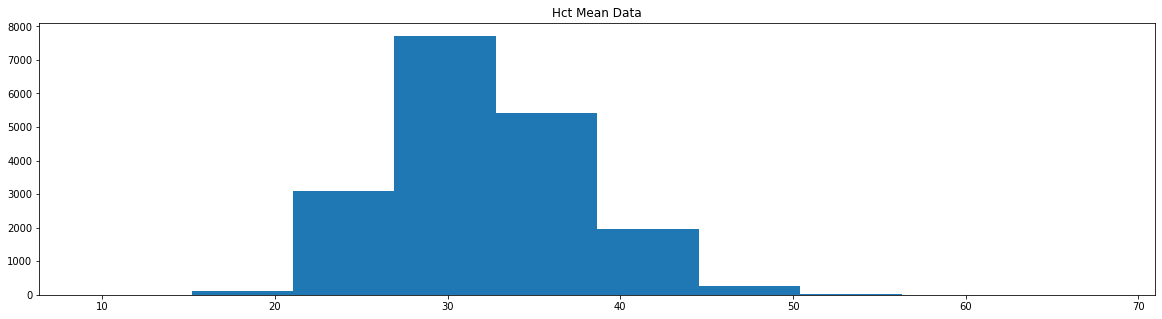

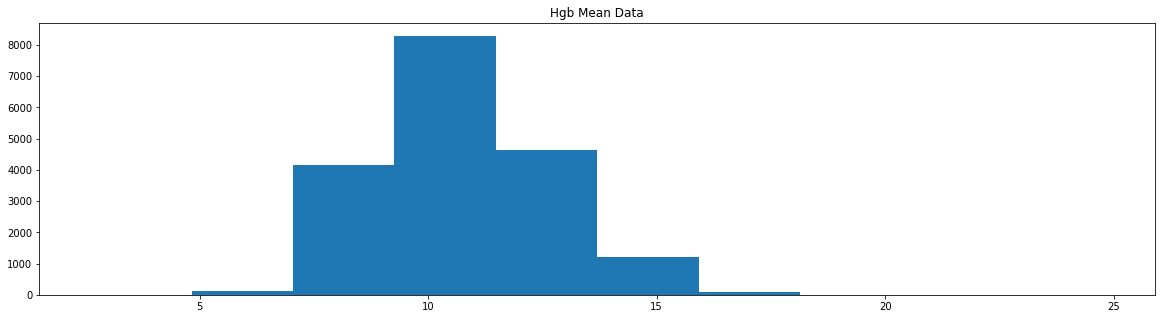

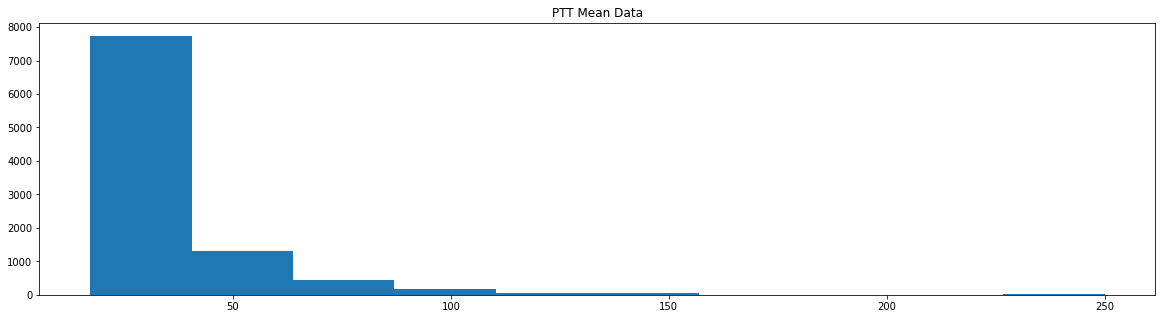

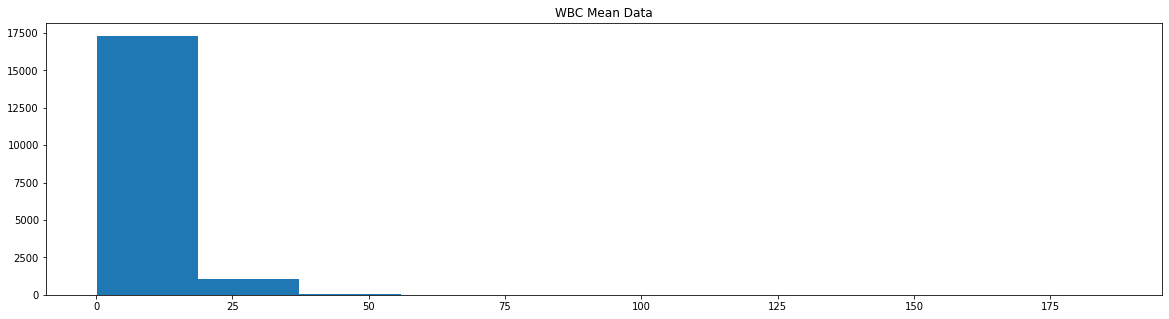

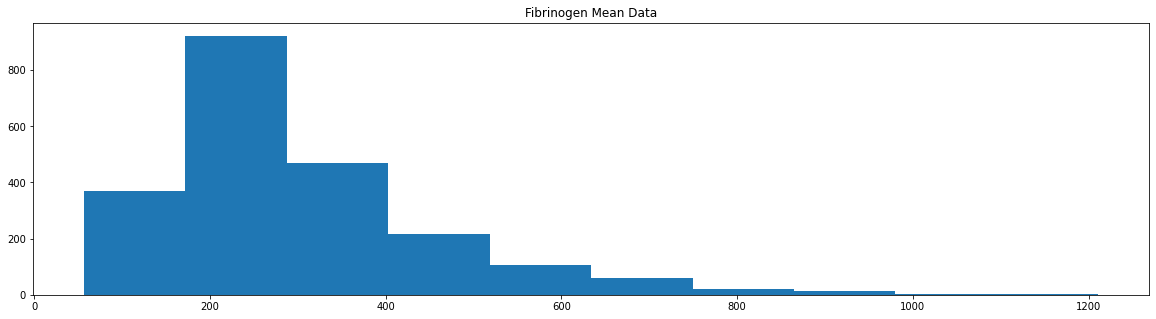

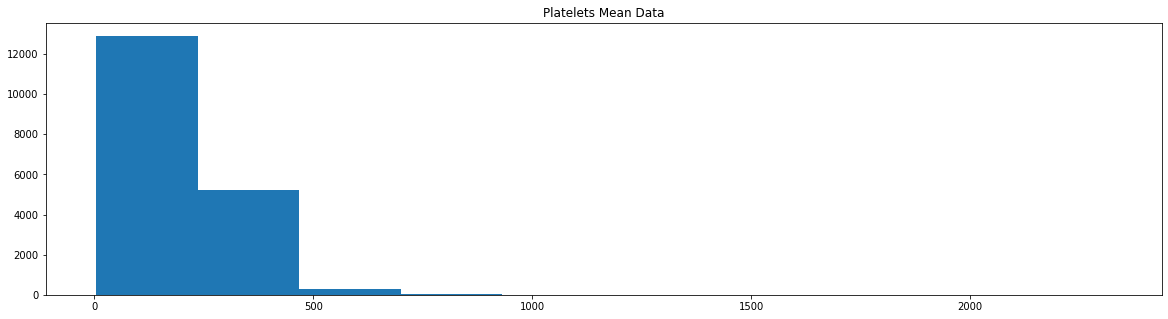

In [30]:
for lab in labs:
    plt.hist(data_mean[lab].dropna())
    plt.title(f'{lab} Mean Data')
    plt.show()

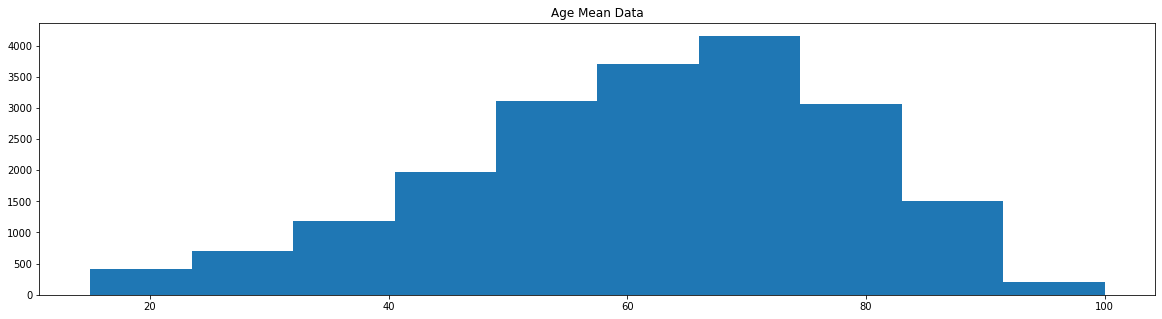

In [31]:
plt.hist(data_mean['Age'].dropna())
plt.title(f'Age Mean Data')    
plt.show()

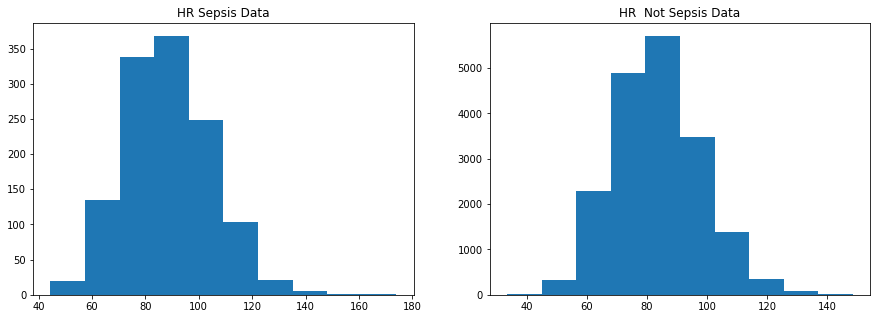

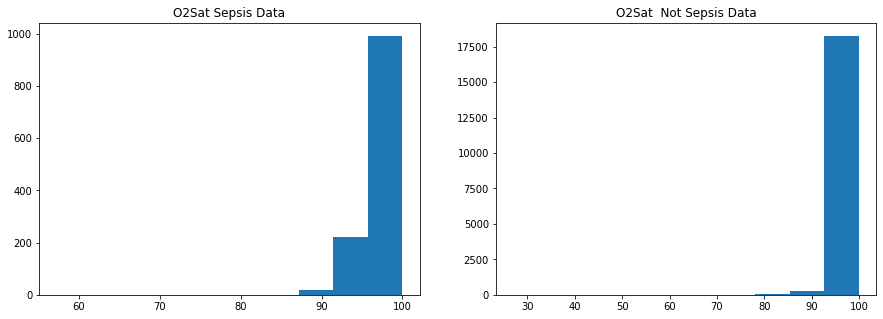

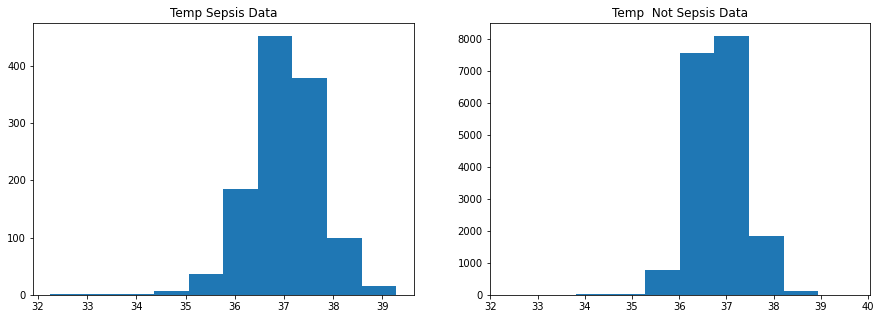

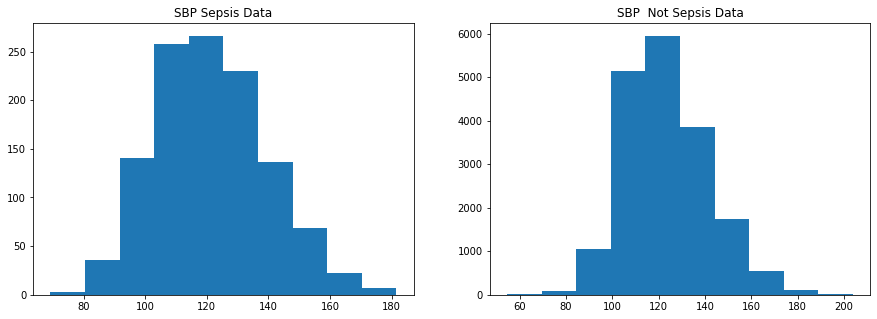

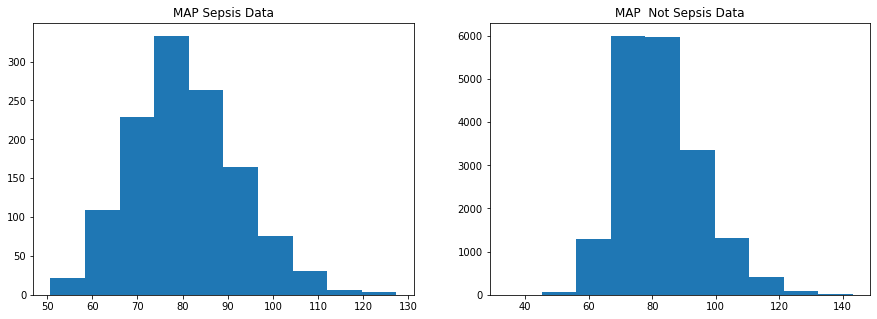

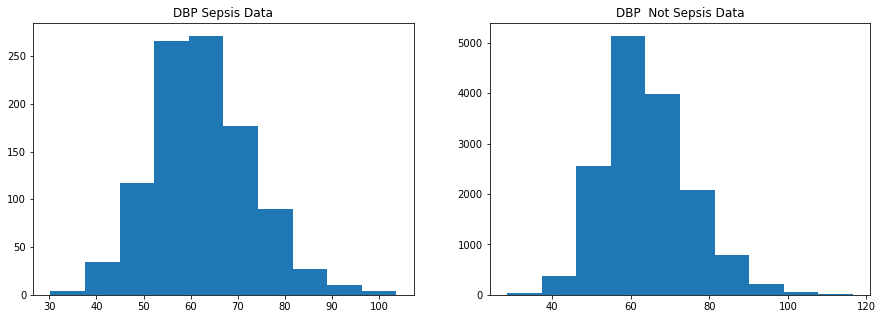

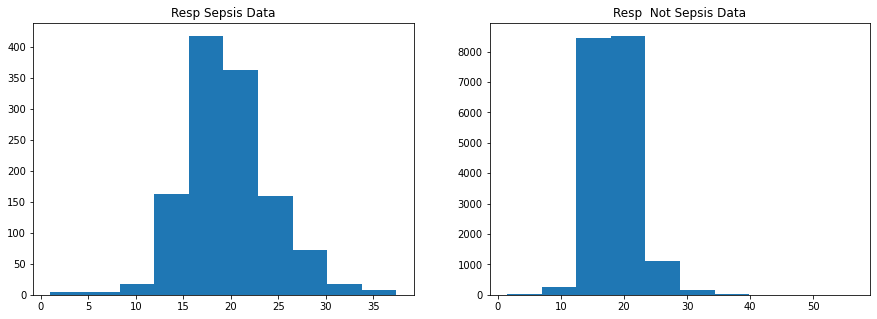

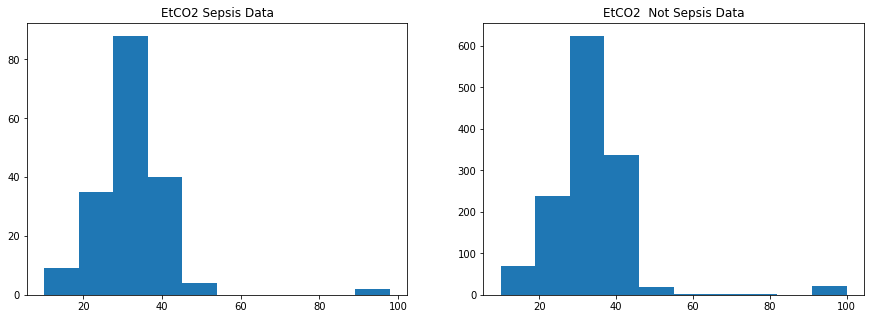

In [32]:
plt.rcParams["figure.figsize"] = (15,5)

for vital in vitals:
    plt.subplot(1, 2, 1)
    plt.hist(data_sepsis_mean[vital].dropna())
    plt.title(f'{vital} Sepsis Data')

    plt.subplot(1, 2, 2)
    plt.hist(data_not_sepsis_mean[vital].dropna())
    plt.title(f'{vital}  Not Sepsis Data')
    
    plt.show()

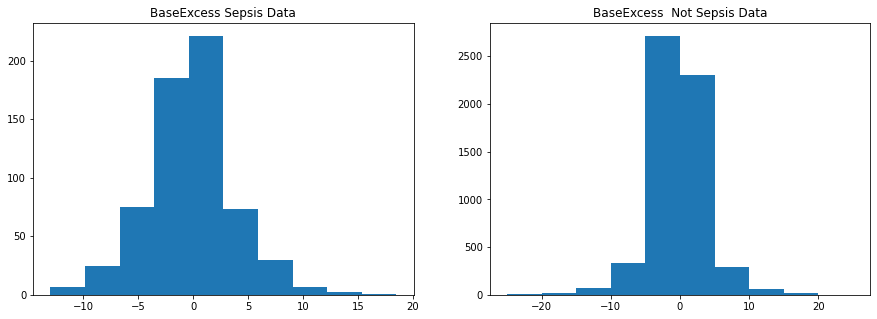

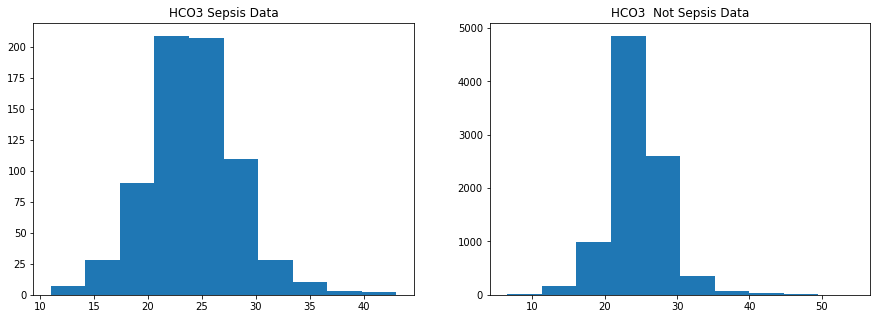

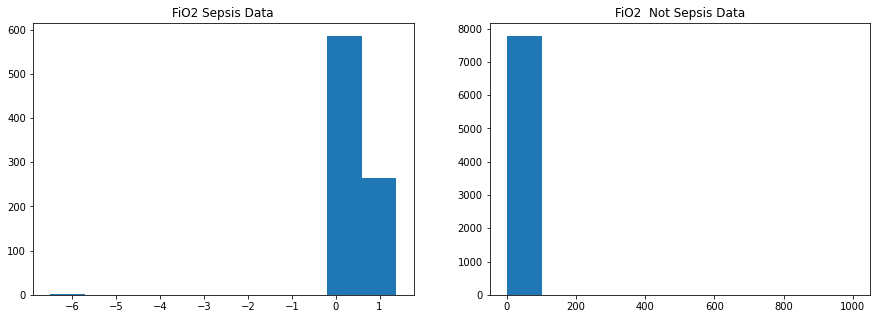

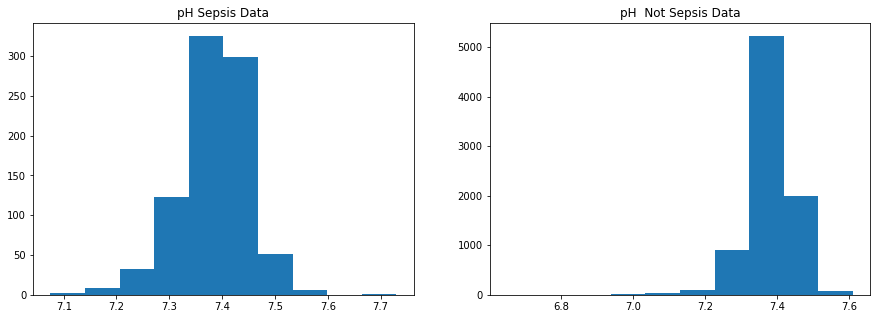

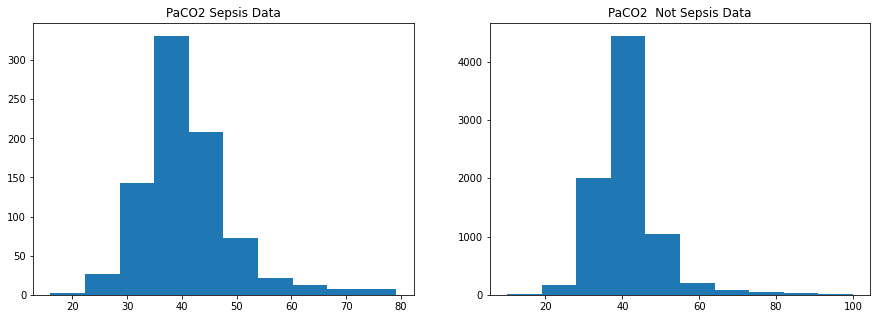

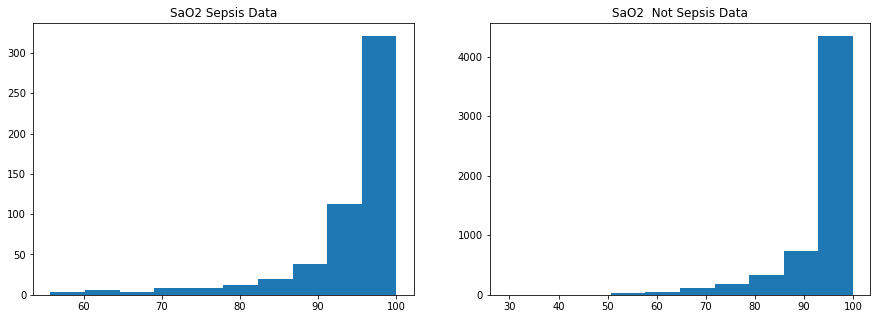

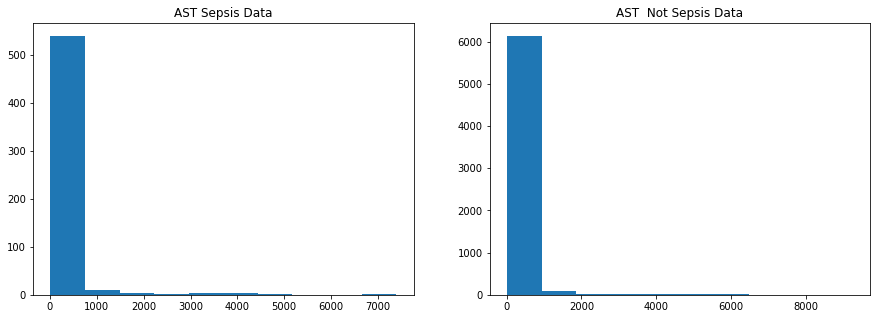

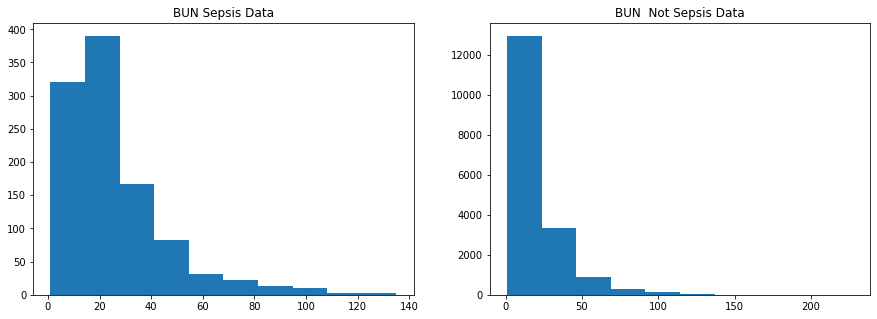

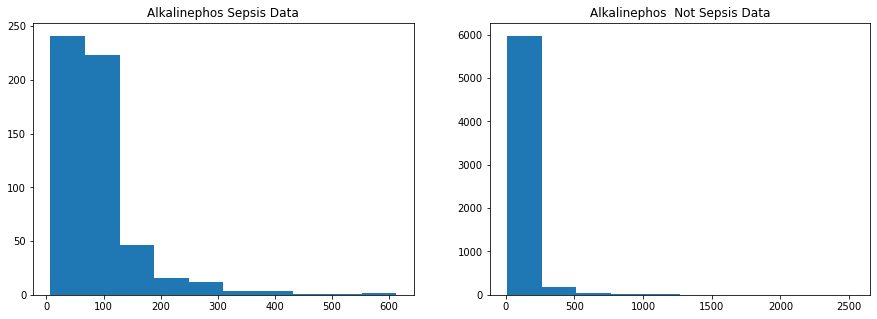

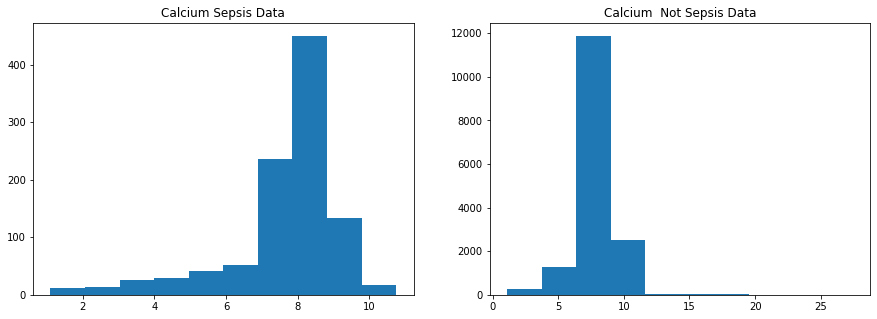

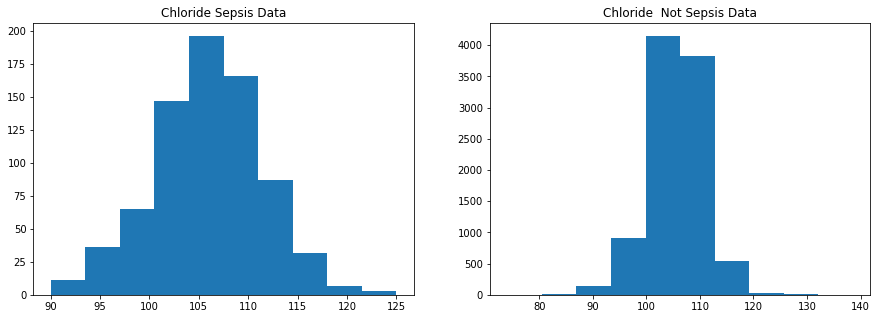

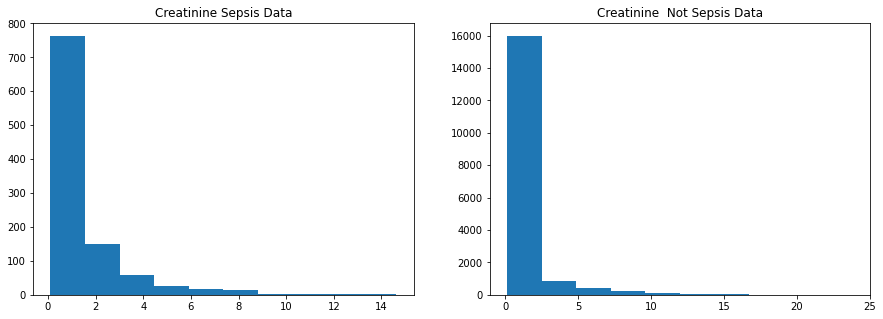

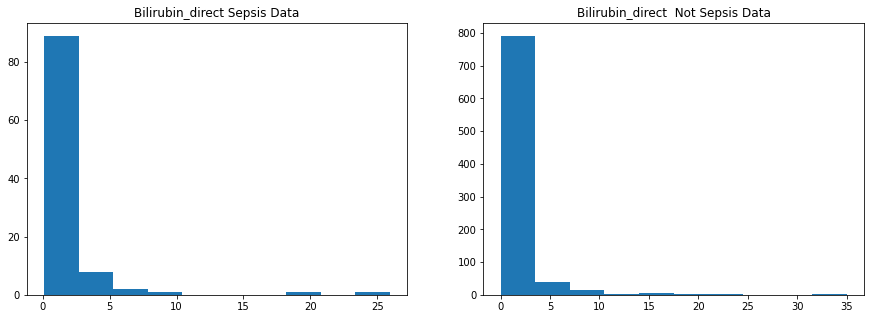

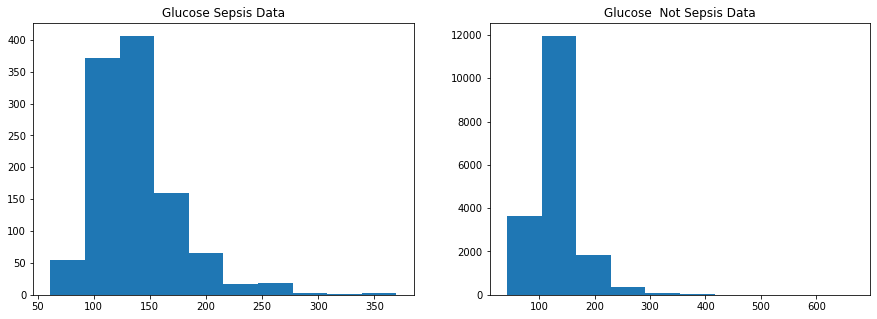

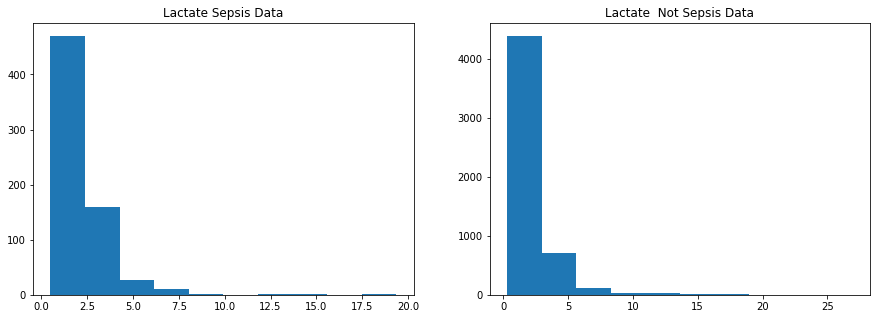

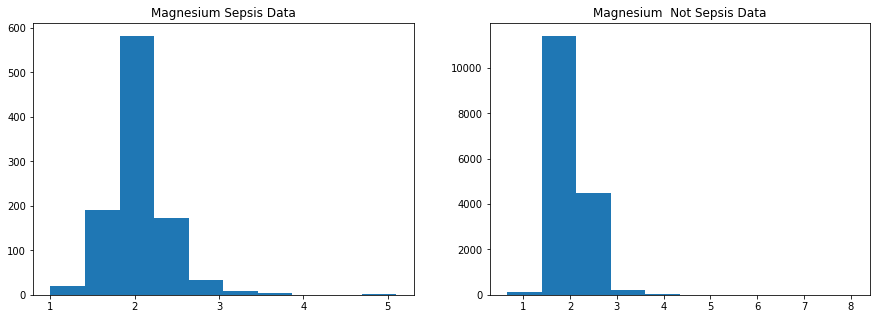

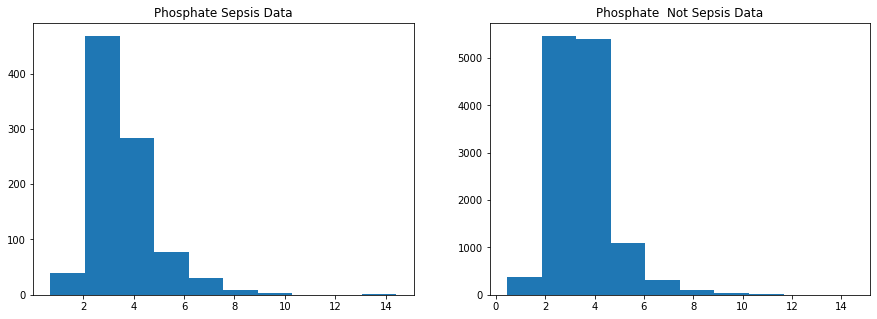

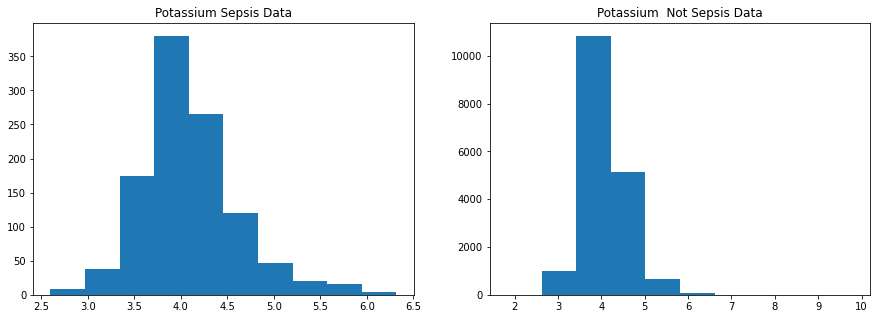

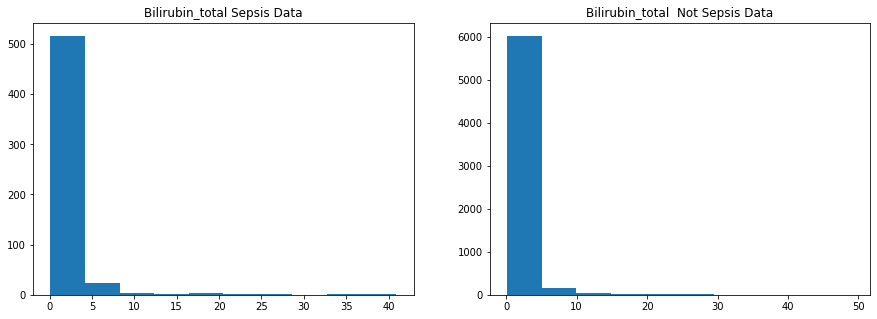

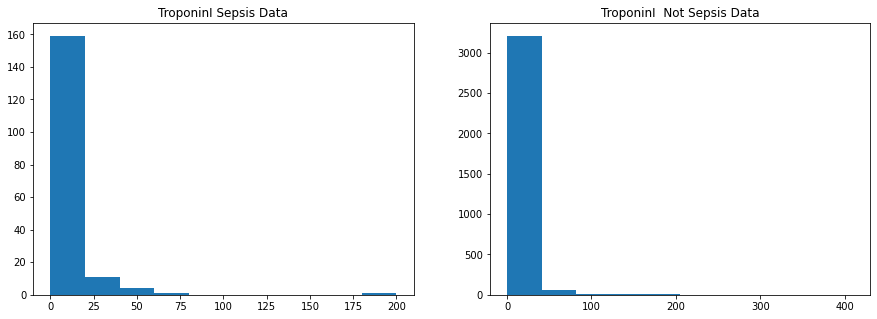

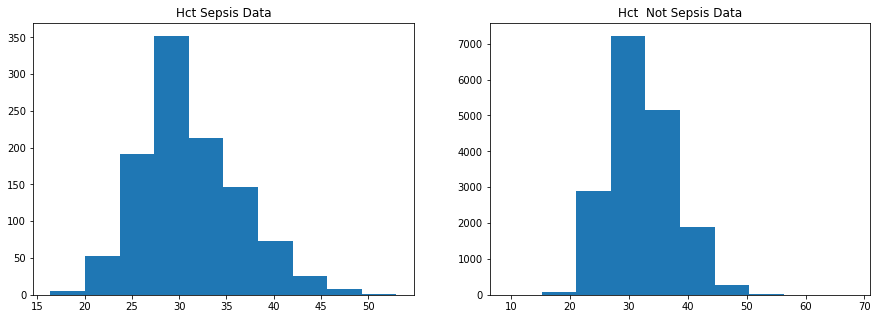

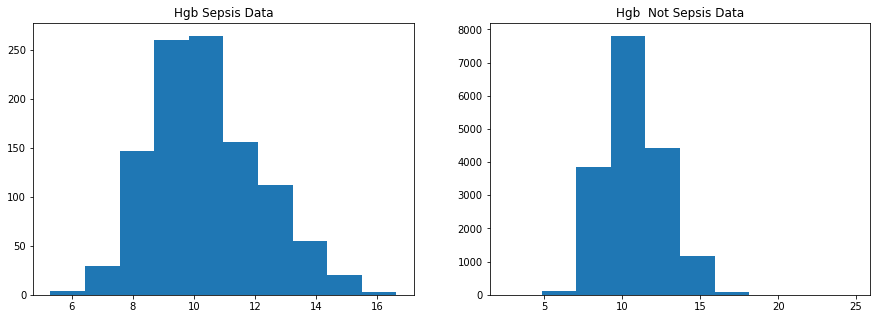

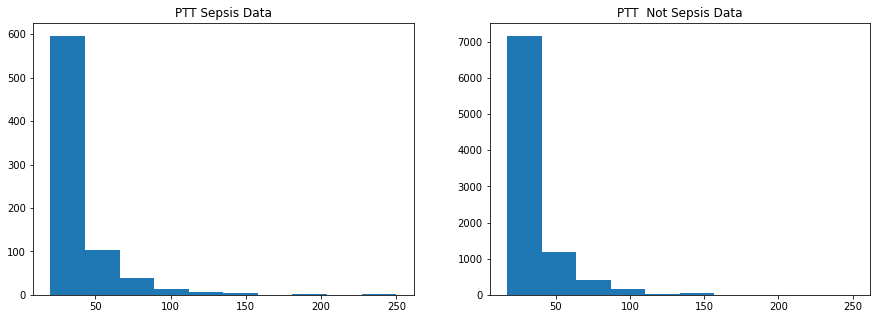

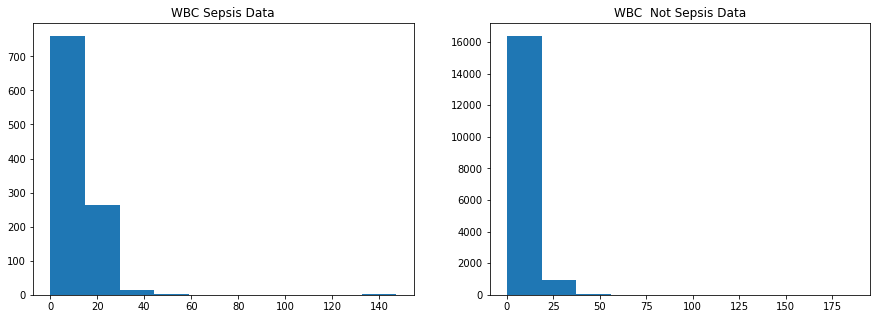

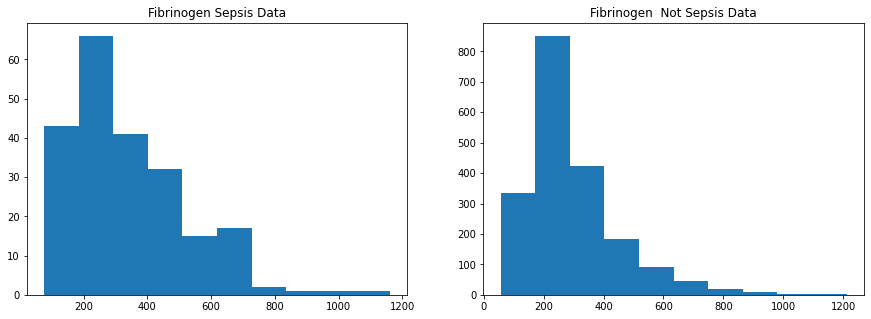

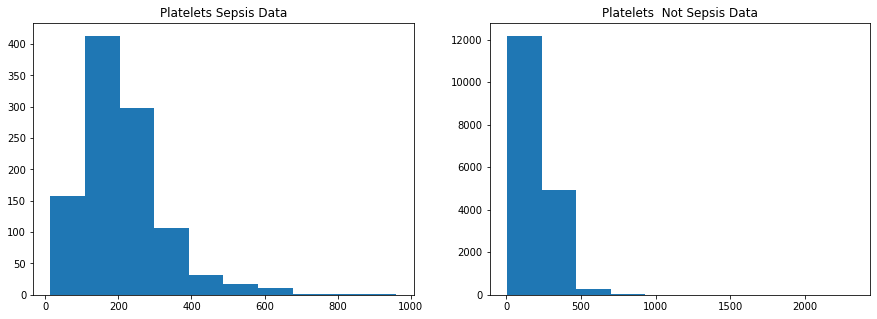

In [33]:
for lab in labs:
    plt.subplot(1, 2, 1)
    plt.hist(data_sepsis_mean[lab].dropna())
    plt.title(f'{lab} Sepsis Data')

    plt.subplot(1, 2, 2)
    plt.hist(data_not_sepsis_mean[lab].dropna())
    plt.title(f'{lab}  Not Sepsis Data')
    
    plt.show()

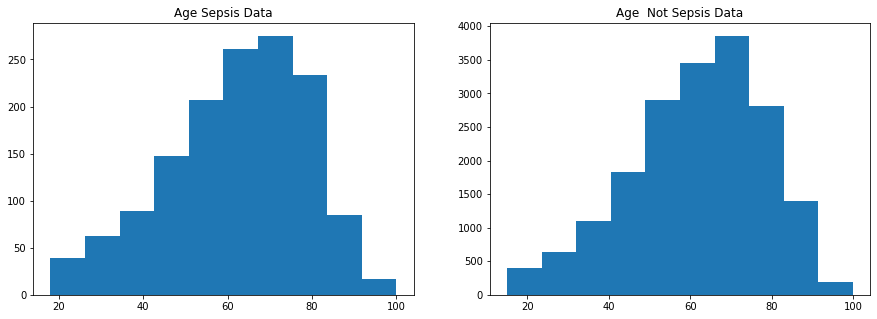

In [34]:
plt.subplot(1, 2, 1)
plt.hist(data_sepsis_mean['Age'].dropna())
plt.title(f'Age Sepsis Data')

plt.subplot(1, 2, 2)
plt.hist(data_not_sepsis_mean['Age'].dropna())
plt.title(f'Age  Not Sepsis Data')

plt.show()

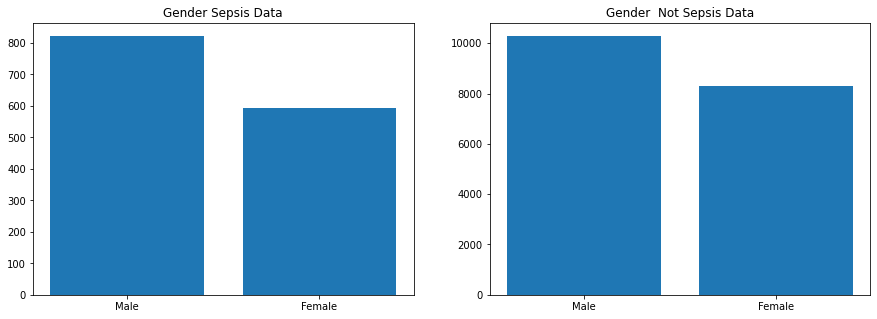

In [35]:
plt.subplot(1, 2, 1)
plt.bar(['Male', 'Female'], list(data_sepsis_mean['Gender'].value_counts()))
plt.title(f'Gender Sepsis Data')

plt.subplot(1, 2, 2)
plt.bar(['Male', 'Female'], list(data_not_sepsis_mean['Gender'].value_counts()))
plt.title(f'Gender  Not Sepsis Data')

plt.show()

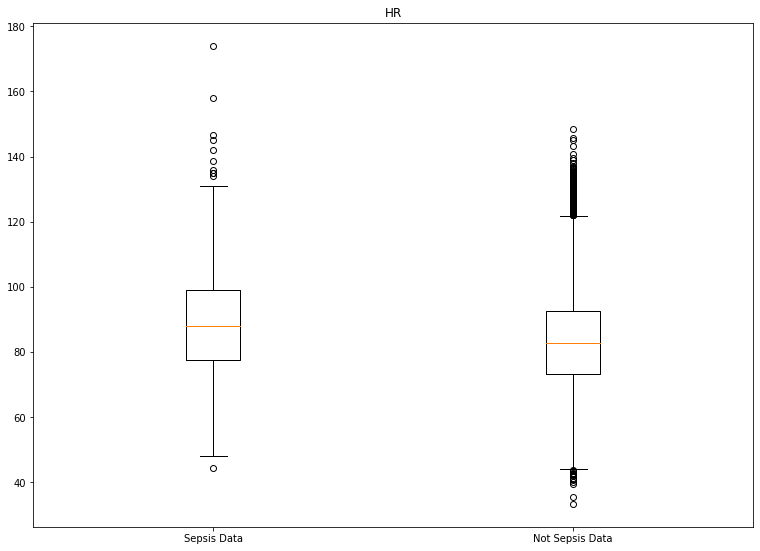

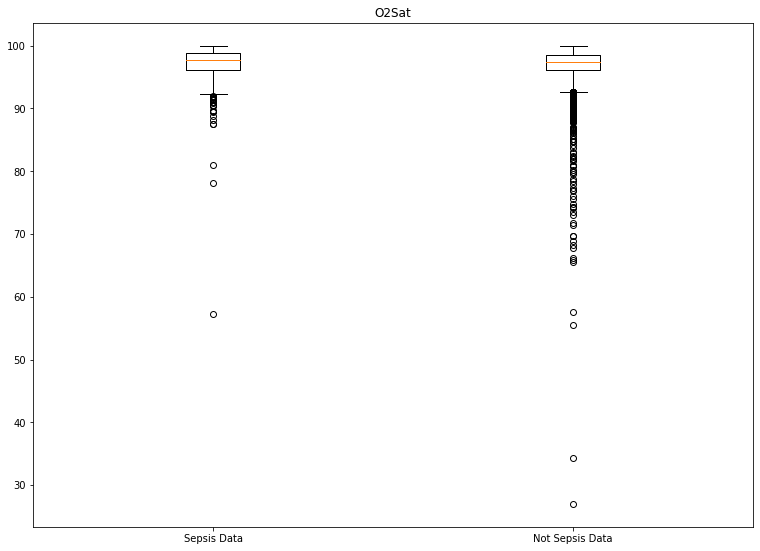

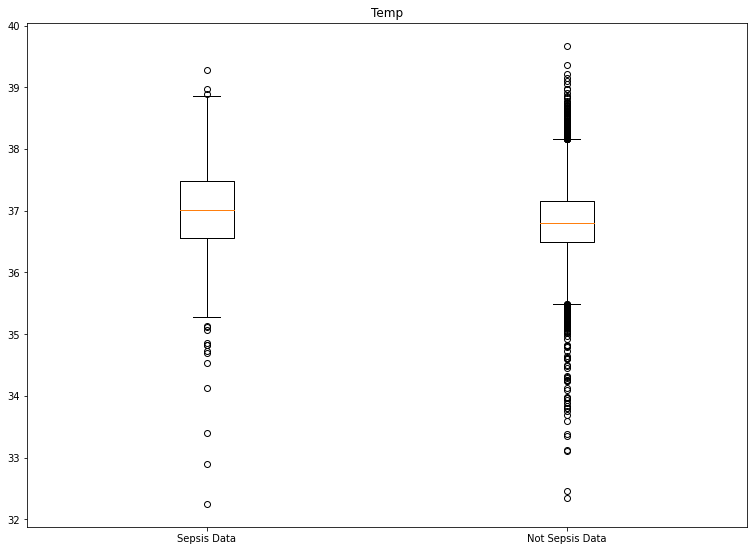

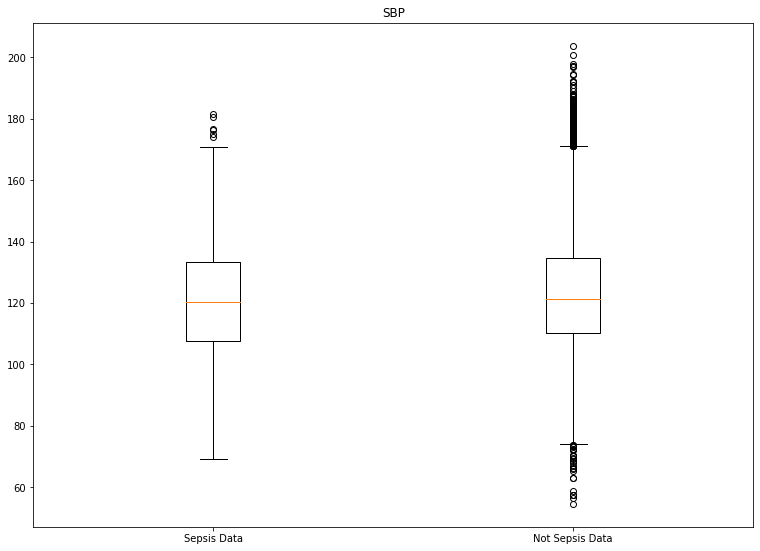

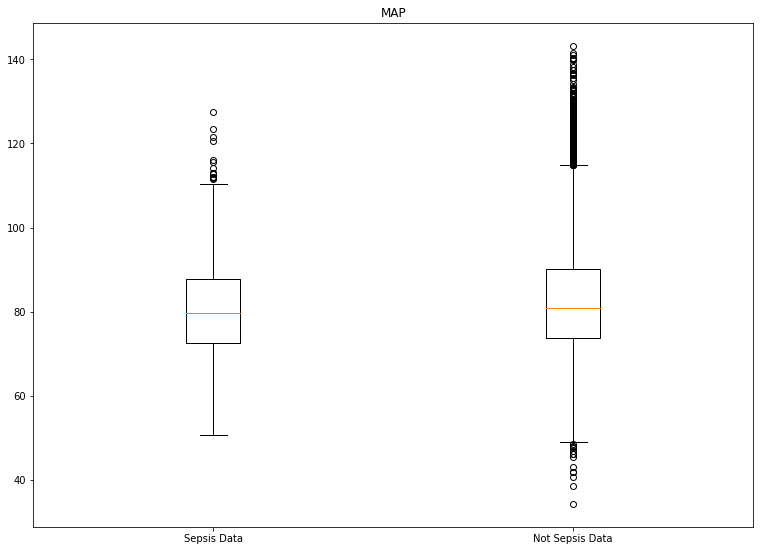

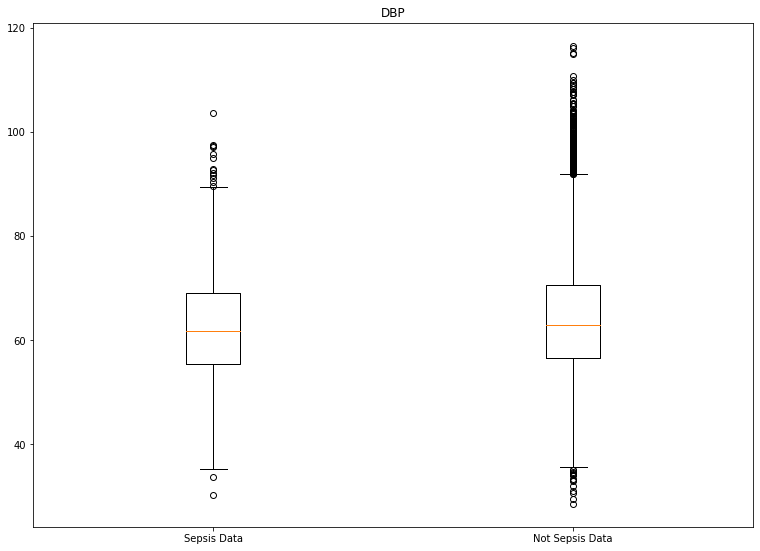

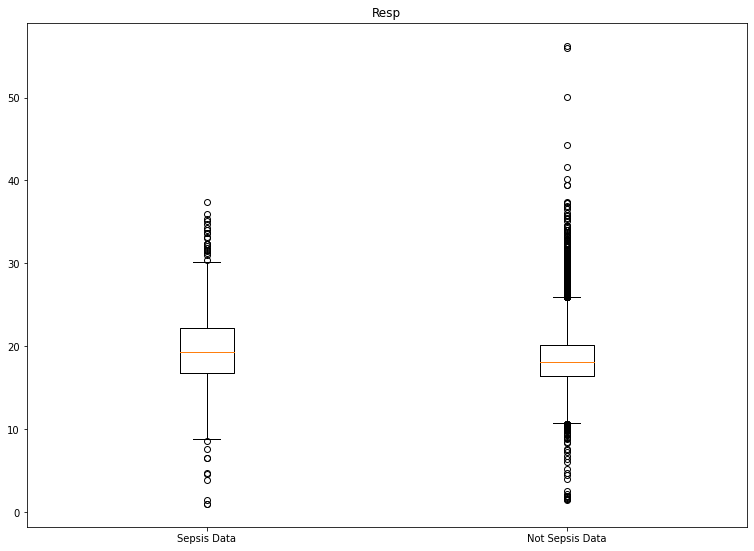

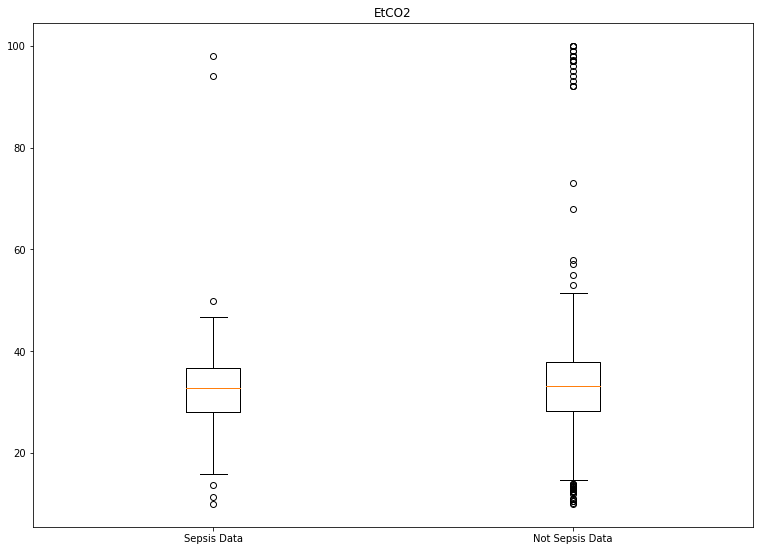

In [36]:
for vital in vitals:
    fig = plt.figure(figsize =(10, 7))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot([np.array(data_sepsis_mean[vital].dropna()), np.array(data_not_sepsis_mean[vital].dropna())])

    # show plot
    ax.set_xticklabels(['Sepsis Data', 'Not Sepsis Data'])
    ax.get_xaxis().tick_bottom()
    plt.title(vital)
    plt.show()

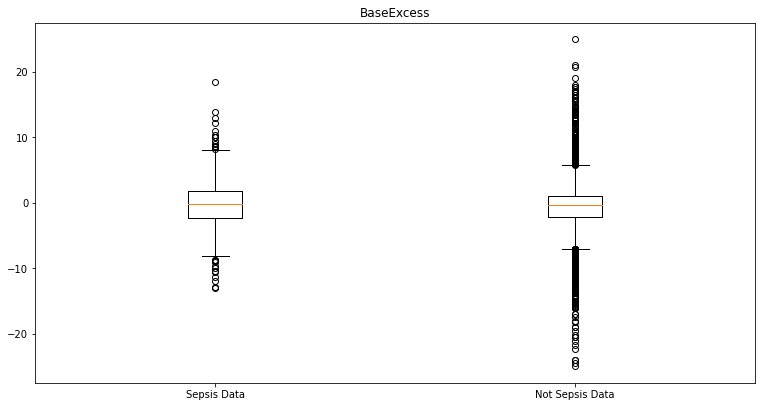

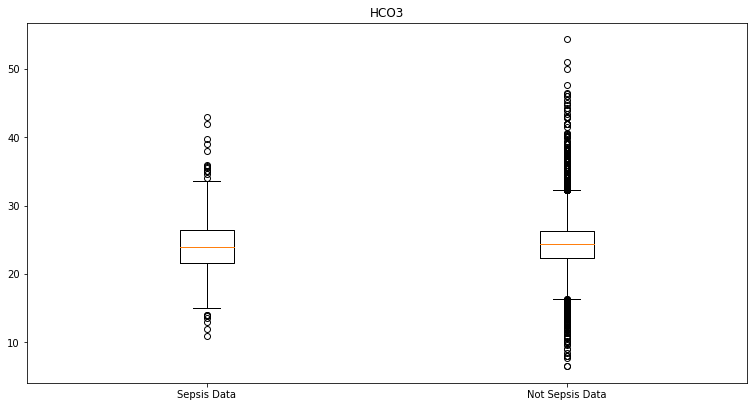

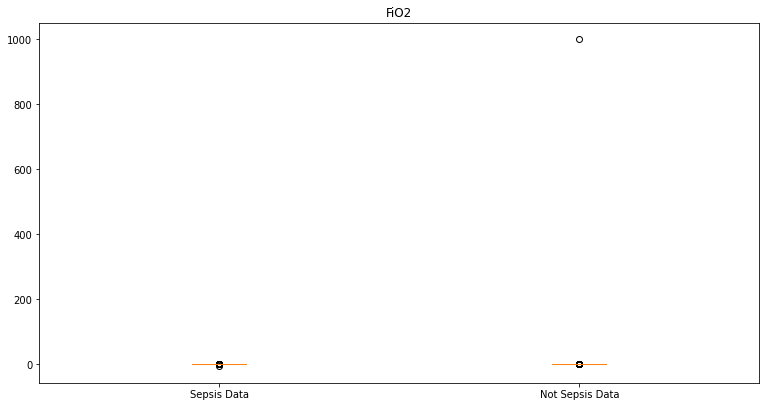

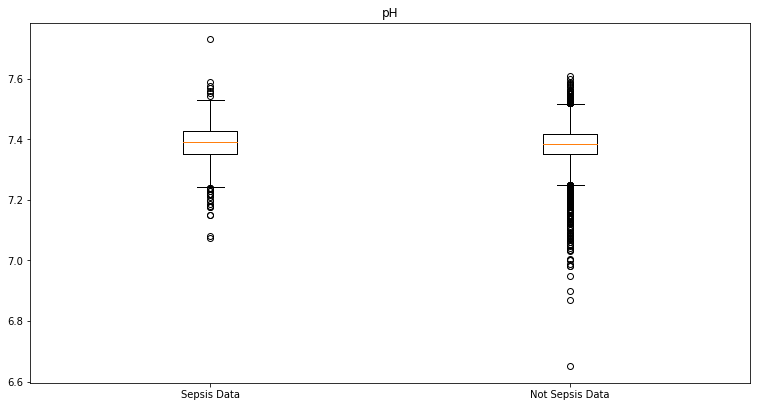

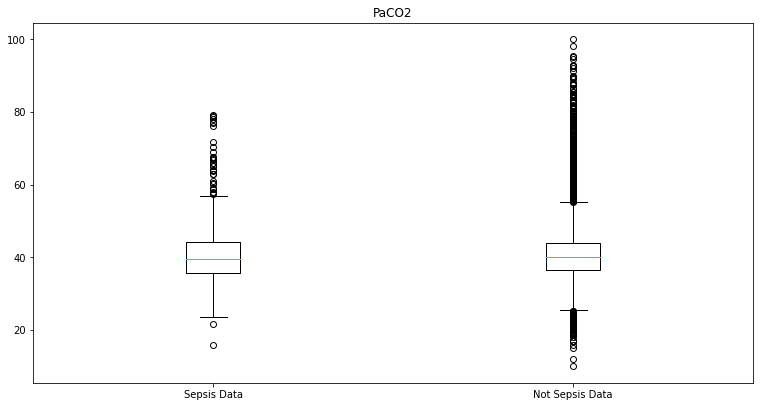

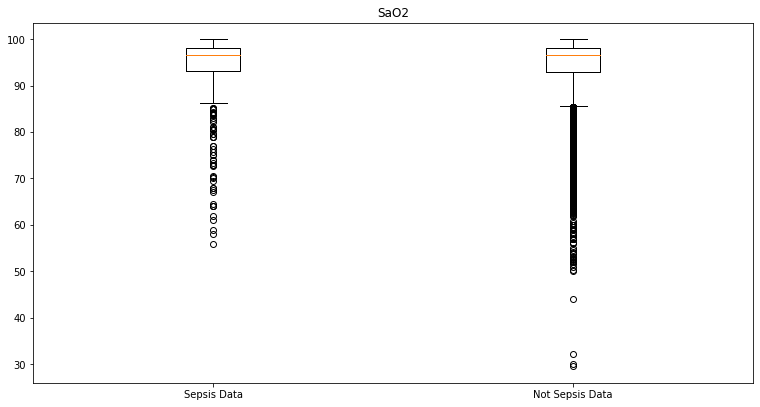

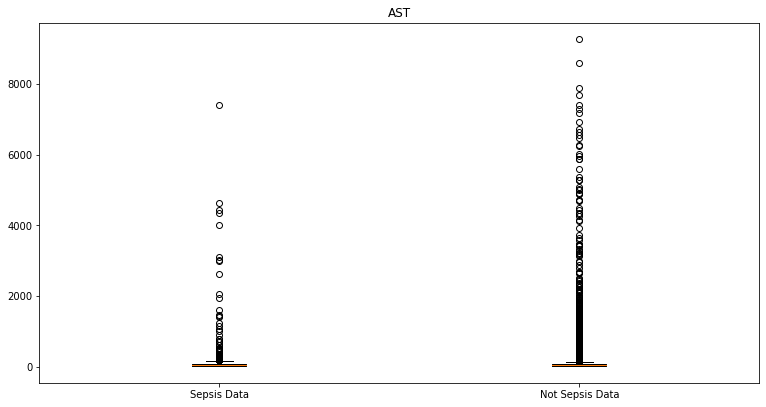

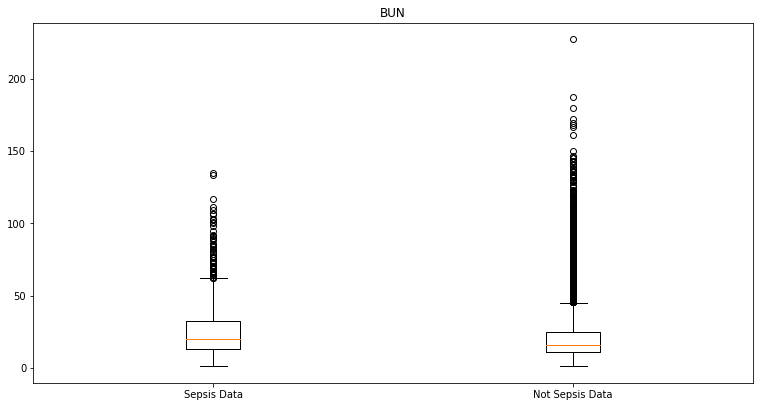

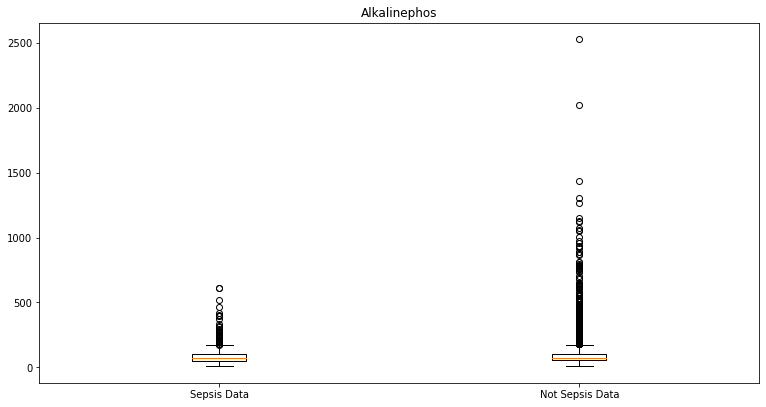

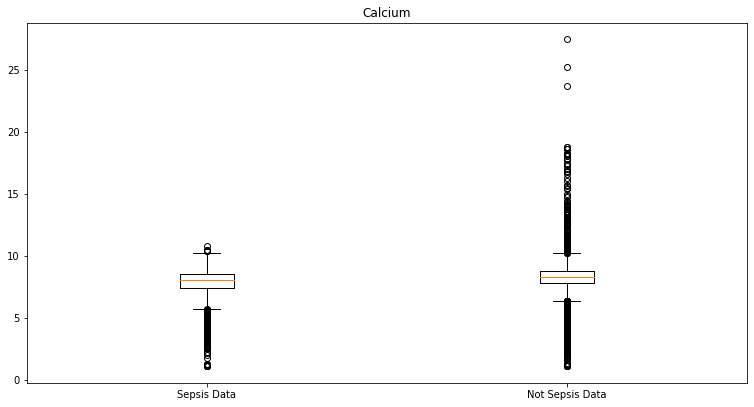

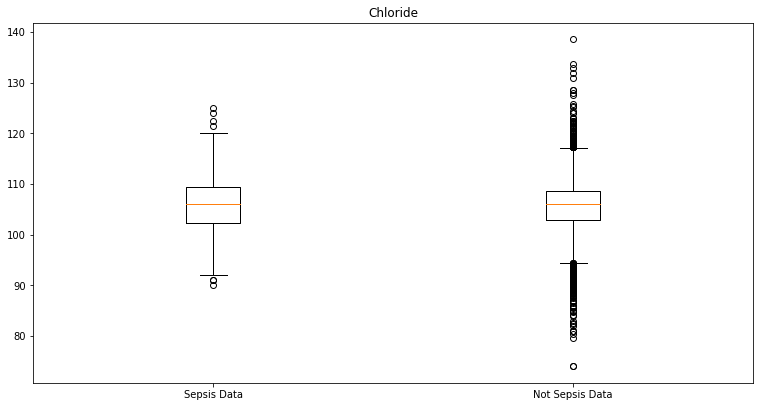

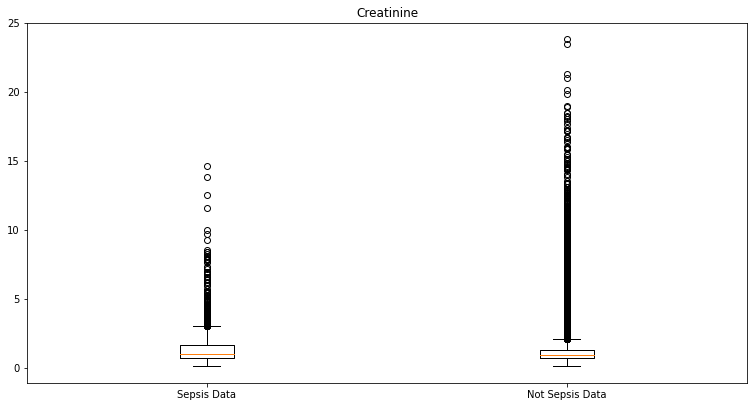

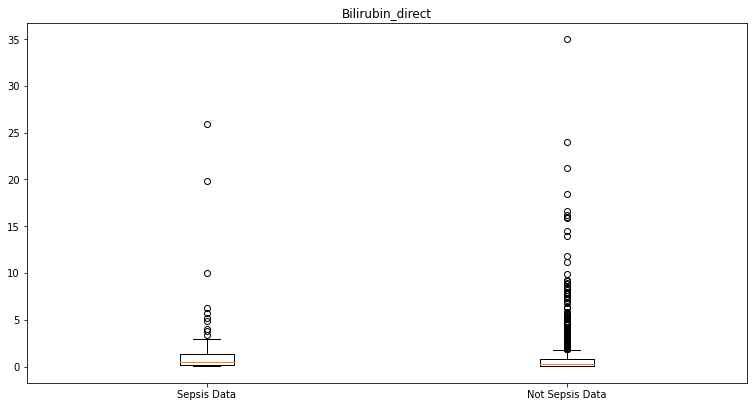

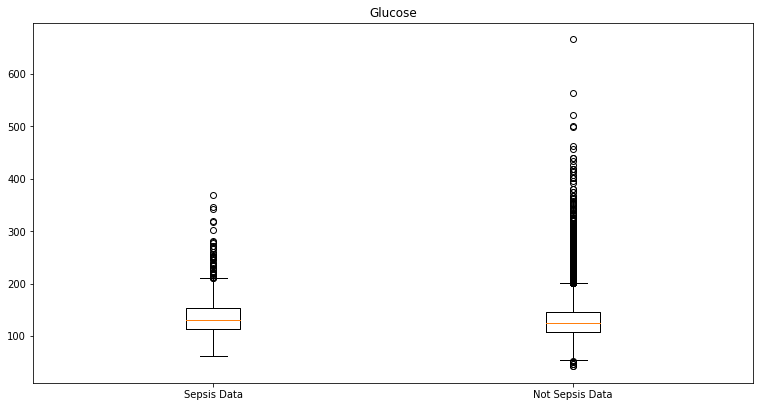

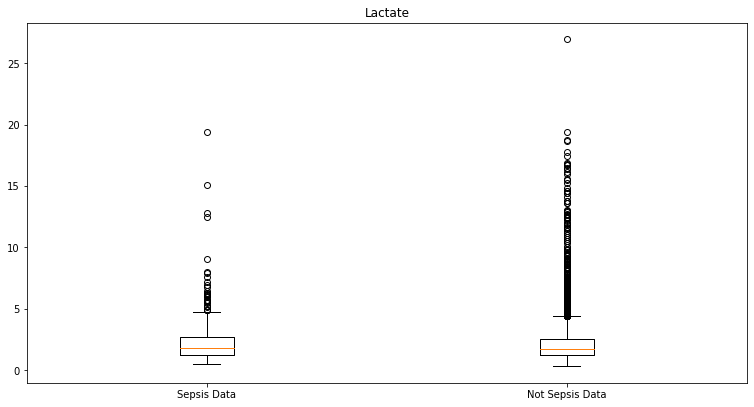

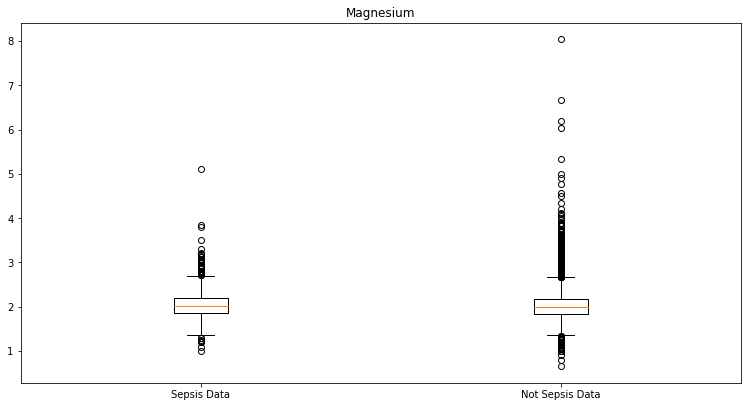

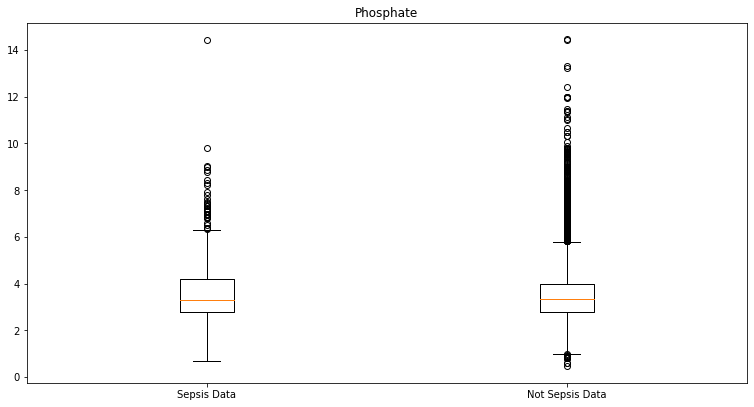

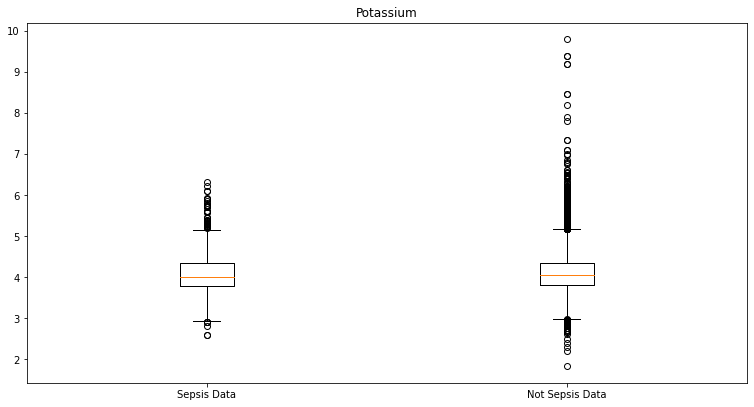

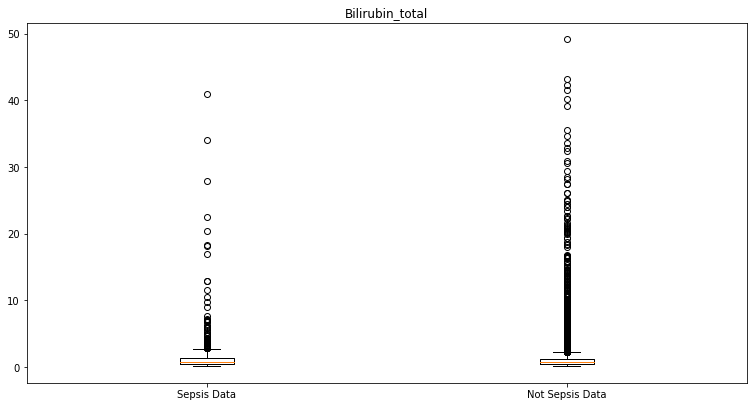

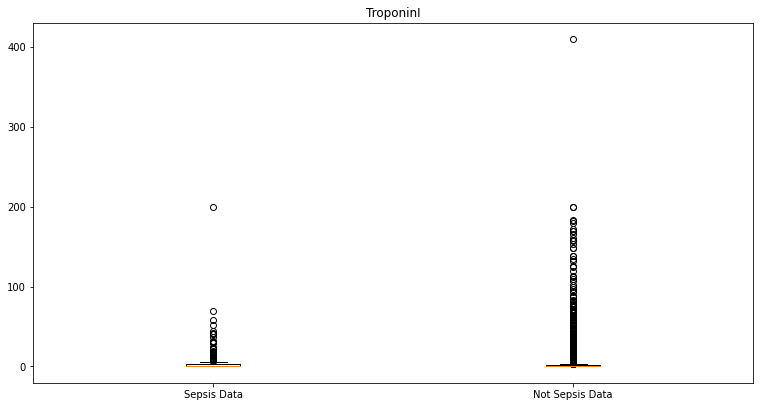

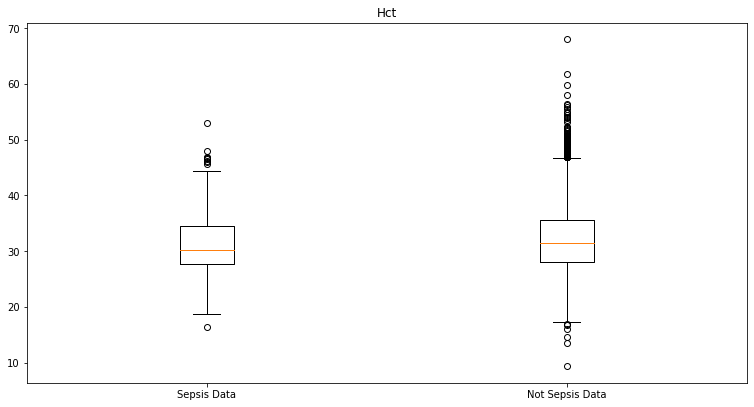

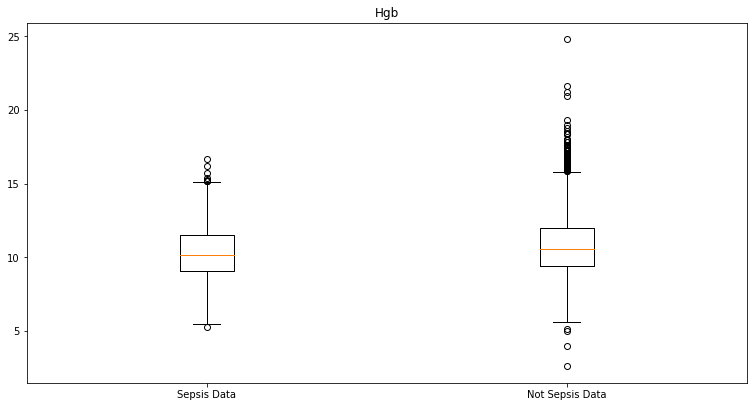

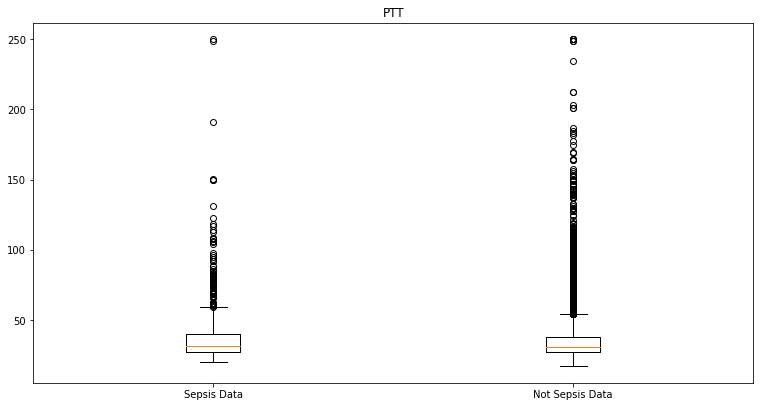

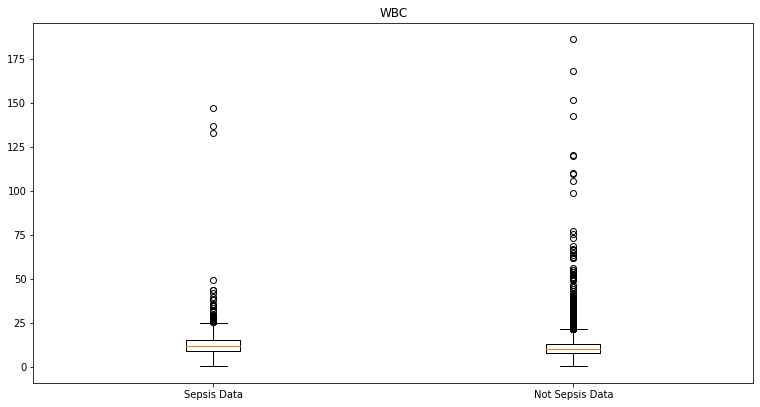

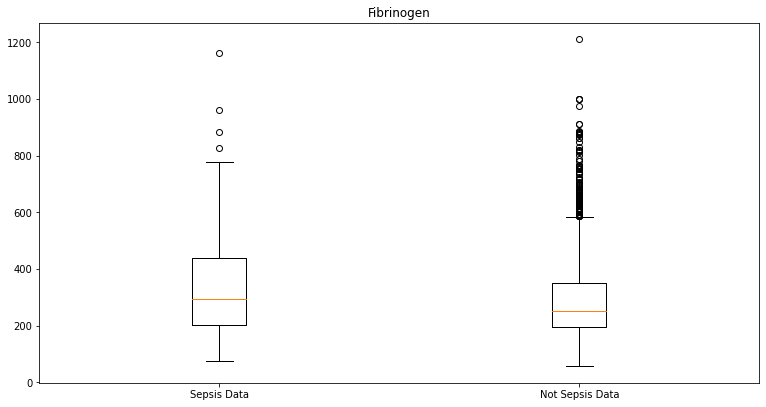

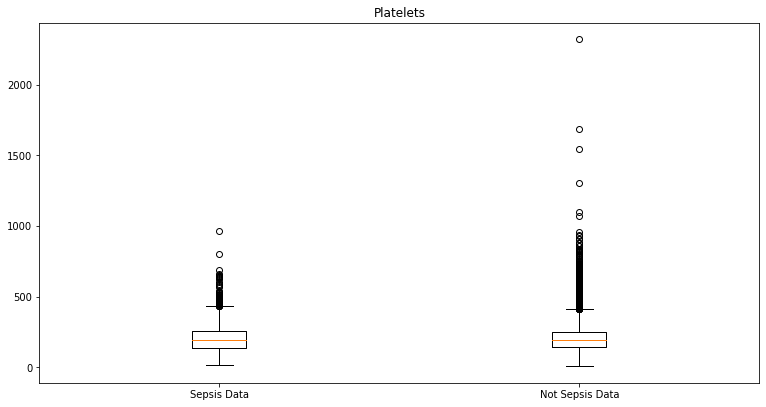

In [37]:
for lab in labs:
    fig = plt.figure(figsize =(10, 5))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot([np.array(data_sepsis_mean[lab].dropna()), np.array(data_not_sepsis_mean[lab].dropna())])

    # show plot
    ax.set_xticklabels(['Sepsis Data', 'Not Sepsis Data'])
    ax.get_xaxis().tick_bottom()
    plt.title(lab)
    plt.show()

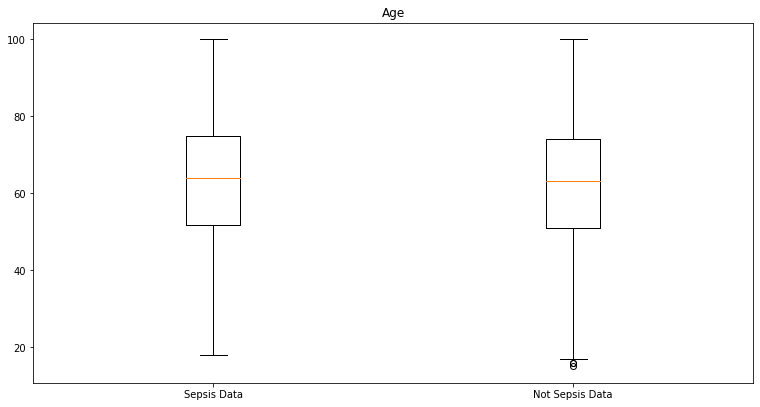

In [38]:
for demog in ['Age']:
    fig = plt.figure(figsize =(10, 5))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot([np.array(data_sepsis_mean[demog].dropna()), np.array(data_not_sepsis_mean[demog].dropna())])

    # show plot
    ax.set_xticklabels(['Sepsis Data', 'Not Sepsis Data'])
    ax.get_xaxis().tick_bottom()
    plt.title(demog)
    plt.show()

In [39]:
for vital in vitals:
    print(f"T-test {vital} results:")
    print(rp.ttest(group1= data_sepsis_mean[vital], group1_name= "Sepsis",
             group2= data_not_sepsis_mean[vital], group2_name= "Not Sepsis"))

T-test HR results:
(     Variable        N       Mean         SD        SE  95% Conf.   Interval
0      Sepsis   1240.0  88.657913  16.177780  0.459418  87.756590  89.559236
1  Not Sepsis  18582.0  83.419974  14.451731  0.106017  83.212172  83.627776
2    combined  19822.0  83.747642  14.620389  0.103845  83.544098  83.951187,                     Independent t-test     results
0  Difference (Sepsis - Not Sepsis) =       5.2379
1                Degrees of freedom =   19820.0000
2                                 t =      12.2607
3             Two side test p value =       0.0000
4            Difference < 0 p value =       1.0000
5            Difference > 0 p value =       0.0000
6                         Cohen's d =       0.3596
7                         Hedge's g =       0.3596
8                     Glass's delta =       0.3238
9                       Pearson's r =       0.0868)
T-test O2Sat results:
(     Variable        N       Mean        SD        SE  95% Conf.   Interval
0      Sep

In [40]:
for lab in labs:
    print(f"T-test {lab} results:")
    print(rp.ttest(group1= data_sepsis_mean[lab], group1_name= "Sepsis",
             group2= data_not_sepsis_mean[lab], group2_name= "Not Sepsis"))

T-test BaseExcess results:
(     Variable       N      Mean        SD        SE  95% Conf.  Interval
0      Sepsis   626.0 -0.244623  3.909509  0.156255  -0.551473  0.062226
1  Not Sepsis  5811.0 -0.509381  3.868871  0.050753  -0.608876 -0.409887
2    combined  6437.0 -0.483634  3.873330  0.048277  -0.578273 -0.388994,                     Independent t-test    results
0  Difference (Sepsis - Not Sepsis) =      0.2648
1                Degrees of freedom =   6435.0000
2                                 t =      1.6251
3             Two side test p value =      0.1042
4            Difference < 0 p value =      0.9479
5            Difference > 0 p value =      0.0521
6                         Cohen's d =      0.0684
7                         Hedge's g =      0.0684
8                     Glass's delta =      0.0677
9                       Pearson's r =      0.0203)
T-test HCO3 results:
(     Variable       N       Mean        SD        SE  95% Conf.   Interval
0      Sepsis   694.0  24.02048

(     Variable        N      Mean        SD        SE  95% Conf.  Interval
0      Sepsis   1036.0  1.567148  1.663246  0.051675   1.465749  1.668547
1  Not Sepsis  17661.0  1.400552  1.736342  0.013066   1.374943  1.426162
2    combined  18697.0  1.409783  1.732749  0.012672   1.384945  1.434622,                     Independent t-test     results
0  Difference (Sepsis - Not Sepsis) =       0.1666
1                Degrees of freedom =   18695.0000
2                                 t =       3.0083
3             Two side test p value =       0.0026
4            Difference < 0 p value =       0.9987
5            Difference > 0 p value =       0.0013
6                         Cohen's d =       0.0962
7                         Hedge's g =       0.0962
8                     Glass's delta =       0.1002
9                       Pearson's r =       0.0220)
T-test Bilirubin_direct results:
(     Variable      N      Mean        SD        SE  95% Conf.  Interval
0      Sepsis  102.0  1.472779  3.

(     Variable       N       Mean         SD        SE  95% Conf.   Interval
0      Sepsis   761.0  38.899031  22.041181  0.798992  37.330537  40.467525
1  Not Sepsis  9008.0  36.786273  18.849545  0.198603  36.396965  37.175581
2    combined  9769.0  36.950855  19.124431  0.193492  36.571571  37.330140,                     Independent t-test    results
0  Difference (Sepsis - Not Sepsis) =      2.1128
1                Degrees of freedom =   9767.0000
2                                 t =      2.9276
3             Two side test p value =      0.0034
4            Difference < 0 p value =      0.9983
5            Difference > 0 p value =      0.0017
6                         Cohen's d =      0.1105
7                         Hedge's g =      0.1105
8                     Glass's delta =      0.0959
9                       Pearson's r =      0.0296)
T-test WBC results:
(     Variable        N       Mean        SD        SE  95% Conf.   Interval
0      Sepsis   1040.0  12.821035  9.000818  0

In [41]:
for vital in vitals:
    flg = True
    print(f"Wilcoxon-test {vital} results:")
    for alter in ['greater', 'less']:
        w_val, p_val = stats.mannwhitneyu(data_sepsis_mean[vital].dropna(),
                                              data_not_sepsis_mean[vital].dropna(),
                                              alternative=alter)
        if p_val <= 0.05:
            print(f"The {alter} Wilcoxon Test Value is = {w_val}")
            print(f"The {alter} Wilcoxon Test P value is = {p_val}")
            print(f"{vital} Wilcoxon {alter} Test P-value was highly significant (below 0.05), Therefore The {vital} Mean is {alter} in Sepsis patients than Non-Sepsis")
            flg = False
            break            
    if flg:
        print(f"{vital} P-value was not highly significant (above 0.05)")
    print()

Wilcoxon-test HR results:
The greater Wilcoxon Test Value is = 13685169.0
The greater Wilcoxon Test P value is = 6.73854174271905e-29
HR Wilcoxon greater Test P-value was highly significant (below 0.05), Therefore The HR Mean is greater in Sepsis patients than Non-Sepsis

Wilcoxon-test O2Sat results:
The greater Wilcoxon Test Value is = 12342357.5
The greater Wilcoxon Test P value is = 3.6332214488023275e-06
O2Sat Wilcoxon greater Test P-value was highly significant (below 0.05), Therefore The O2Sat Mean is greater in Sepsis patients than Non-Sepsis

Wilcoxon-test Temp results:
The greater Wilcoxon Test Value is = 12903159.5
The greater Wilcoxon Test P value is = 2.1689110854637835e-27
Temp Wilcoxon greater Test P-value was highly significant (below 0.05), Therefore The Temp Mean is greater in Sepsis patients than Non-Sepsis

Wilcoxon-test SBP results:
The less Wilcoxon Test Value is = 10184075.5
The less Wilcoxon Test P value is = 0.0004735744756942632
SBP Wilcoxon less Test P-value w

In [42]:
for lab in labs:
    flg = True
    print(f"Wilcoxon-test {lab} results:")
    for alter in ['greater', 'less']:
        w_val, p_val = stats.mannwhitneyu(data_sepsis_mean[lab].dropna(),
                                              data_not_sepsis_mean[lab].dropna(),
                                              alternative=alter)
        if p_val <= 0.05:
            print(f"The {alter} Wilcoxon Test Value is = {w_val}")
            print(f"The {alter} Wilcoxon Test P value is = {p_val}")
            print(f"{lab} Wilcoxon {alter} Test P-value was highly significant (below 0.05), Therefore The {lab} Mean is {alter} in Sepsis patients than Non-Sepsis")
            flg = False
            break            
    if flg:
        print(f"{lab} P-value was not highly significant (above 0.05)")
    print()

Wilcoxon-test BaseExcess results:
The greater Wilcoxon Test Value is = 1895999.5
The greater Wilcoxon Test P value is = 0.04030940939824521
BaseExcess Wilcoxon greater Test P-value was highly significant (below 0.05), Therefore The BaseExcess Mean is greater in Sepsis patients than Non-Sepsis

Wilcoxon-test HCO3 results:
The less Wilcoxon Test Value is = 2941263.0
The less Wilcoxon Test P value is = 0.0015956639266405197
HCO3 Wilcoxon less Test P-value was highly significant (below 0.05), Therefore The HCO3 Mean is less in Sepsis patients than Non-Sepsis

Wilcoxon-test FiO2 results:
The greater Wilcoxon Test Value is = 3592277.5
The greater Wilcoxon Test P value is = 2.048696902078671e-05
FiO2 Wilcoxon greater Test P-value was highly significant (below 0.05), Therefore The FiO2 Mean is greater in Sepsis patients than Non-Sepsis

Wilcoxon-test pH results:
The greater Wilcoxon Test Value is = 3766178.0
The greater Wilcoxon Test P value is = 0.0005854093260414433
pH Wilcoxon greater Test 